This notebook shows how to apply the ResNet model by [Patrick Mineault](http://xcorr.net) (Team 4) in [Berens et al. (2017)](https://www.biorxiv.org/content/biorxiv/early/2017/08/18/177956) to an arbitrary dataset. 

This model uses a ResNet to predict spike trains from calcium traces. The initial filters of the ResNet are adapted through an attention mechanism based on latent variables learned from a mixture density network. A universal ResNet is first fit to all the available data, and optionally refined on a recording-by-recording basis. 

Here, I do inference based on a learned mixture density network and a ResNet. The code is not very flexible; if you'd like to apply it to other datasets, clone the [github repository](https://github.com/patrickmineault/spikefinder_submission), replace the contents of the `spikefinder.train` and `spikefinder.test` folders with your own recordings in the same format, and re-run this notebook. Comment out the training cells to do inference on pretrained models.

In [47]:
%matplotlib inline

import cPickle as pickle
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Latent variables learned from mixture density network

We want like the inference network to adapt to the statistics of the input. For example, if a calcium trace has sluggish dynamics, we want the inference network to act more as a high pass filter; conversely for  calcium traces with fast dynamics. Thus, we use an unsupervised method to learn statistics of the input, a mixture density network.

The mixture density network is a three layer LSTM with 256 cells that predicts the probability of a  calcium observation given the past. It operates on minibatches of 1024 time samples. This particular MDN architecture was originally used as a [generative model for handwriting](). By taking the mean LSTM activations for each 1024 sample long mini-batch we obtain 1534 latent variables, which are reduced to 32 via an SVD. This network can be trained in this way (expects data in `spikefinder.test` and `spikefinder.train`):

In [48]:
!python train_and_eval_mdn.py --operation=train

Training
2018-01-17 20:16:11.177043: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.1 instructions, but these are available on your machine and could speed up CPU computations.
2018-01-17 20:16:11.177067: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.2 instructions, but these are available on your machine and could speed up CPU computations.
2018-01-17 20:16:11.177072: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX instructions, but these are available on your machine and could speed up CPU computations.
2018-01-17 20:16:11.177075: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX2 instructions, but these are available on your machine and could speed up CPU computations.
2018-01-17 20:16:11.177079: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow libra

54/2310 (epoch 0), train_loss = -0.158, valid_loss = -0.154, time/batch = 1.272
55/2310 (epoch 0), train_loss = 0.002, valid_loss = -0.118, time/batch = 1.233
56/2310 (epoch 0), train_loss = -0.216, valid_loss = -0.234, time/batch = 1.299
57/2310 (epoch 0), train_loss = -0.329, valid_loss = -0.228, time/batch = 1.305
58/2310 (epoch 0), train_loss = -0.003, valid_loss = -0.318, time/batch = 1.273
59/2310 (epoch 0), train_loss = -0.804, valid_loss = -0.267, time/batch = 1.275
60/2310 (epoch 0), train_loss = -0.358, valid_loss = -0.446, time/batch = 1.282
61/2310 (epoch 0), train_loss = 0.757, valid_loss = -0.241, time/batch = 1.292
62/2310 (epoch 0), train_loss = 0.904, valid_loss = -0.239, time/batch = 1.244
63/2310 (epoch 0), train_loss = 0.694, valid_loss = -0.260, time/batch = 1.270
64/2310 (epoch 0), train_loss = 0.616, valid_loss = -0.238, time/batch = 1.261
65/2310 (epoch 0), train_loss = 0.588, valid_loss = -0.232, time/batch = 1.285
66/2310 (epoch 0), train_loss = 0.466, valid_l

154/2310 (epoch 1), train_loss = -1.344, valid_loss = -1.385, time/batch = 1.360
155/2310 (epoch 1), train_loss = -1.535, valid_loss = -1.382, time/batch = 1.254
156/2310 (epoch 1), train_loss = -1.503, valid_loss = -1.395, time/batch = 1.296
157/2310 (epoch 1), train_loss = -0.718, valid_loss = -1.384, time/batch = 1.246
158/2310 (epoch 1), train_loss = -1.559, valid_loss = -1.428, time/batch = 1.241
159/2310 (epoch 1), train_loss = -1.592, valid_loss = -1.415, time/batch = 1.229
160/2310 (epoch 1), train_loss = -1.457, valid_loss = -1.434, time/batch = 1.216
161/2310 (epoch 1), train_loss = -1.389, valid_loss = -1.440, time/batch = 1.278
162/2310 (epoch 1), train_loss = -1.517, valid_loss = -1.420, time/batch = 1.272
163/2310 (epoch 1), train_loss = -1.391, valid_loss = -1.468, time/batch = 1.347
164/2310 (epoch 1), train_loss = -1.605, valid_loss = -1.444, time/batch = 1.307
165/2310 (epoch 1), train_loss = -1.643, valid_loss = -1.438, time/batch = 1.316
166/2310 (epoch 1), train_lo

256/2310 (epoch 1), train_loss = -1.486, valid_loss = -1.537, time/batch = 1.327
257/2310 (epoch 1), train_loss = -1.217, valid_loss = -1.533, time/batch = 1.293
258/2310 (epoch 1), train_loss = -1.604, valid_loss = -1.561, time/batch = 1.313
259/2310 (epoch 1), train_loss = -1.716, valid_loss = -1.539, time/batch = 1.307
260/2310 (epoch 1), train_loss = -1.784, valid_loss = -1.559, time/batch = 1.249
261/2310 (epoch 1), train_loss = -1.660, valid_loss = -1.533, time/batch = 1.282
262/2310 (epoch 1), train_loss = -1.645, valid_loss = -1.548, time/batch = 1.282
263/2310 (epoch 1), train_loss = -1.575, valid_loss = -1.546, time/batch = 1.263
264/2310 (epoch 1), train_loss = -1.488, valid_loss = -1.547, time/batch = 1.354
265/2310 (epoch 1), train_loss = -0.814, valid_loss = -1.553, time/batch = 1.326
266/2310 (epoch 1), train_loss = -1.410, valid_loss = -1.537, time/batch = 1.283
267/2310 (epoch 1), train_loss = -1.500, valid_loss = -1.536, time/batch = 1.327
268/2310 (epoch 1), train_lo

353/2310 (epoch 2), train_loss = -1.575, valid_loss = -1.676, time/batch = 1.274
354/2310 (epoch 2), train_loss = -1.280, valid_loss = -1.657, time/batch = 1.262
355/2310 (epoch 2), train_loss = -1.699, valid_loss = -1.652, time/batch = 1.277
356/2310 (epoch 2), train_loss = -1.692, valid_loss = -1.665, time/batch = 1.273
357/2310 (epoch 2), train_loss = -1.632, valid_loss = -1.674, time/batch = 1.292
358/2310 (epoch 2), train_loss = -1.623, valid_loss = -1.669, time/batch = 1.303
359/2310 (epoch 2), train_loss = -1.622, valid_loss = -1.674, time/batch = 1.234
360/2310 (epoch 2), train_loss = -1.730, valid_loss = -1.686, time/batch = 1.305
361/2310 (epoch 2), train_loss = -1.273, valid_loss = -1.666, time/batch = 1.230
362/2310 (epoch 2), train_loss = -1.690, valid_loss = -1.645, time/batch = 1.245
363/2310 (epoch 2), train_loss = -1.763, valid_loss = -1.680, time/batch = 1.280
364/2310 (epoch 2), train_loss = -1.650, valid_loss = -1.676, time/batch = 1.250
365/2310 (epoch 2), train_lo

455/2310 (epoch 2), train_loss = -1.620, valid_loss = -1.691, time/batch = 1.242
456/2310 (epoch 2), train_loss = -1.615, valid_loss = -1.694, time/batch = 1.290
457/2310 (epoch 2), train_loss = -1.840, valid_loss = -1.683, time/batch = 1.247
458/2310 (epoch 2), train_loss = -1.806, valid_loss = -1.719, time/batch = 1.274
459/2310 (epoch 2), train_loss = -1.613, valid_loss = -1.708, time/batch = 1.281
460/2310 (epoch 2), train_loss = -0.183, valid_loss = -1.663, time/batch = 1.243
461/2310 (epoch 2), train_loss = -0.946, valid_loss = -1.670, time/batch = 1.251
[63, 89, 96, 112, 120, 121, 128, 185, 213, 345, 347, 368, 376, 377, 384, 441, 469, 492, 514, 529, 573, 576, 611, 654, 656, 673, 693, 709, 714, 719, 735, 744, 761, 832, 841, 855, 904, 910, 912, 967, 970, 1017, 1044, 1048, 1049, 1096, 1114, 1156, 1178, 1180, 1190, 1191, 1204, 1248, 1272, 1301, 1424, 1447, 1458, 1504, 1509, 1510, 1514, 1535]
462/2310 (epoch 3), train_loss = -1.602, valid_loss = -1.645, time/batch = 1.317
463/2310 (e

552/2310 (epoch 3), train_loss = -0.540, valid_loss = -1.541, time/batch = 1.273
553/2310 (epoch 3), train_loss = -1.414, valid_loss = -1.641, time/batch = 1.267
554/2310 (epoch 3), train_loss = -1.863, valid_loss = -1.539, time/batch = 1.269
555/2310 (epoch 3), train_loss = -1.553, valid_loss = -1.663, time/batch = 1.274
556/2310 (epoch 3), train_loss = -1.288, valid_loss = -1.577, time/batch = 1.254
557/2310 (epoch 3), train_loss = -1.188, valid_loss = -1.592, time/batch = 1.264
558/2310 (epoch 3), train_loss = -1.270, valid_loss = -1.669, time/batch = 1.247
559/2310 (epoch 3), train_loss = -1.537, valid_loss = -1.633, time/batch = 1.268
560/2310 (epoch 3), train_loss = -1.821, valid_loss = -1.663, time/batch = 1.284
561/2310 (epoch 3), train_loss = -1.001, valid_loss = -1.684, time/batch = 1.292
562/2310 (epoch 3), train_loss = -1.643, valid_loss = -1.689, time/batch = 1.238
563/2310 (epoch 3), train_loss = -1.694, valid_loss = -1.694, time/batch = 1.311
564/2310 (epoch 3), train_lo

649/2310 (epoch 4), train_loss = -1.382, valid_loss = -1.719, time/batch = 1.267
650/2310 (epoch 4), train_loss = -1.430, valid_loss = -1.714, time/batch = 1.289
651/2310 (epoch 4), train_loss = -1.551, valid_loss = -1.710, time/batch = 1.290
652/2310 (epoch 4), train_loss = -1.702, valid_loss = -1.704, time/batch = 1.227
653/2310 (epoch 4), train_loss = -1.702, valid_loss = -1.724, time/batch = 1.286
654/2310 (epoch 4), train_loss = -1.621, valid_loss = -1.727, time/batch = 1.297
655/2310 (epoch 4), train_loss = -1.675, valid_loss = -1.734, time/batch = 1.275
656/2310 (epoch 4), train_loss = -1.509, valid_loss = -1.738, time/batch = 1.266
657/2310 (epoch 4), train_loss = -1.380, valid_loss = -1.747, time/batch = 1.264
658/2310 (epoch 4), train_loss = -1.586, valid_loss = -1.757, time/batch = 1.249
659/2310 (epoch 4), train_loss = -1.795, valid_loss = -1.762, time/batch = 1.259
660/2310 (epoch 4), train_loss = -1.631, valid_loss = -1.763, time/batch = 1.227
661/2310 (epoch 4), train_lo

751/2310 (epoch 4), train_loss = -1.813, valid_loss = -1.672, time/batch = 1.289
752/2310 (epoch 4), train_loss = -1.714, valid_loss = -1.669, time/batch = 1.247
753/2310 (epoch 4), train_loss = -1.754, valid_loss = -1.684, time/batch = 1.254
754/2310 (epoch 4), train_loss = -1.807, valid_loss = -1.684, time/batch = 1.247
755/2310 (epoch 4), train_loss = -1.825, valid_loss = -1.692, time/batch = 1.247
756/2310 (epoch 4), train_loss = -1.996, valid_loss = -1.704, time/batch = 1.274
757/2310 (epoch 4), train_loss = -1.953, valid_loss = -1.714, time/batch = 1.266
758/2310 (epoch 4), train_loss = -2.025, valid_loss = -1.699, time/batch = 1.283
759/2310 (epoch 4), train_loss = -1.685, valid_loss = -1.690, time/batch = 1.260
760/2310 (epoch 4), train_loss = -1.652, valid_loss = -1.699, time/batch = 1.295
761/2310 (epoch 4), train_loss = -1.547, valid_loss = -1.733, time/batch = 1.275
762/2310 (epoch 4), train_loss = -1.295, valid_loss = -1.750, time/batch = 1.243
763/2310 (epoch 4), train_lo

849/2310 (epoch 5), train_loss = -1.927, valid_loss = -1.779, time/batch = 1.251
850/2310 (epoch 5), train_loss = -1.775, valid_loss = -1.788, time/batch = 1.284
851/2310 (epoch 5), train_loss = -1.524, valid_loss = -1.817, time/batch = 1.268
852/2310 (epoch 5), train_loss = -1.803, valid_loss = -1.820, time/batch = 1.267
853/2310 (epoch 5), train_loss = -1.304, valid_loss = -1.821, time/batch = 1.311
854/2310 (epoch 5), train_loss = -1.263, valid_loss = -1.835, time/batch = 1.270
855/2310 (epoch 5), train_loss = -1.831, valid_loss = -1.828, time/batch = 1.221
856/2310 (epoch 5), train_loss = -2.186, valid_loss = -1.827, time/batch = 1.338
857/2310 (epoch 5), train_loss = -2.144, valid_loss = -1.838, time/batch = 1.243
858/2310 (epoch 5), train_loss = -1.937, valid_loss = -1.833, time/batch = 1.325
859/2310 (epoch 5), train_loss = -0.116, valid_loss = -1.764, time/batch = 1.283
860/2310 (epoch 5), train_loss = -1.543, valid_loss = -1.786, time/batch = 1.356
861/2310 (epoch 5), train_lo

947/2310 (epoch 6), train_loss = -1.896, valid_loss = -1.740, time/batch = 1.276
948/2310 (epoch 6), train_loss = -1.853, valid_loss = -1.775, time/batch = 1.312
949/2310 (epoch 6), train_loss = -1.888, valid_loss = -1.732, time/batch = 1.302
950/2310 (epoch 6), train_loss = -1.378, valid_loss = -1.699, time/batch = 1.265
951/2310 (epoch 6), train_loss = -0.530, valid_loss = -1.698, time/batch = 1.278
952/2310 (epoch 6), train_loss = -0.594, valid_loss = -1.698, time/batch = 1.277
953/2310 (epoch 6), train_loss = -0.772, valid_loss = -1.741, time/batch = 1.264
954/2310 (epoch 6), train_loss = -1.436, valid_loss = -1.744, time/batch = 1.294
955/2310 (epoch 6), train_loss = -1.962, valid_loss = -1.693, time/batch = 1.288
956/2310 (epoch 6), train_loss = -2.153, valid_loss = -1.651, time/batch = 1.255
957/2310 (epoch 6), train_loss = -1.798, valid_loss = -1.665, time/batch = 1.297
958/2310 (epoch 6), train_loss = -1.341, valid_loss = -1.673, time/batch = 1.270
959/2310 (epoch 6), train_lo

1048/2310 (epoch 6), train_loss = -2.234, valid_loss = -1.801, time/batch = 1.260
1049/2310 (epoch 6), train_loss = -1.932, valid_loss = -1.805, time/batch = 1.294
1050/2310 (epoch 6), train_loss = -1.418, valid_loss = -1.800, time/batch = 1.269
1051/2310 (epoch 6), train_loss = -1.642, valid_loss = -1.815, time/batch = 1.239
1052/2310 (epoch 6), train_loss = -1.509, valid_loss = -1.794, time/batch = 1.259
1053/2310 (epoch 6), train_loss = -1.358, valid_loss = -1.779, time/batch = 1.288
1054/2310 (epoch 6), train_loss = -1.426, valid_loss = -1.785, time/batch = 1.264
1055/2310 (epoch 6), train_loss = -1.849, valid_loss = -1.762, time/batch = 1.306
1056/2310 (epoch 6), train_loss = -1.667, valid_loss = -1.749, time/batch = 1.339
1057/2310 (epoch 6), train_loss = -1.995, valid_loss = -1.775, time/batch = 1.272
1058/2310 (epoch 6), train_loss = -1.479, valid_loss = -1.760, time/batch = 1.304
1059/2310 (epoch 6), train_loss = -1.662, valid_loss = -1.772, time/batch = 1.267
1060/2310 (epoch

1144/2310 (epoch 7), train_loss = -2.009, valid_loss = -1.854, time/batch = 1.253
1145/2310 (epoch 7), train_loss = -1.029, valid_loss = -1.846, time/batch = 1.309
1146/2310 (epoch 7), train_loss = -1.444, valid_loss = -1.863, time/batch = 1.261
1147/2310 (epoch 7), train_loss = 0.192, valid_loss = -1.844, time/batch = 1.271
1148/2310 (epoch 7), train_loss = -1.681, valid_loss = -1.849, time/batch = 1.287
1149/2310 (epoch 7), train_loss = -2.031, valid_loss = -1.836, time/batch = 1.278
1150/2310 (epoch 7), train_loss = -1.481, valid_loss = -1.808, time/batch = 1.262
1151/2310 (epoch 7), train_loss = -1.200, valid_loss = -1.766, time/batch = 1.294
1152/2310 (epoch 7), train_loss = -1.344, valid_loss = -1.836, time/batch = 1.261
1153/2310 (epoch 7), train_loss = -1.336, valid_loss = -1.777, time/batch = 1.383
1154/2310 (epoch 7), train_loss = -1.270, valid_loss = -1.778, time/batch = 1.267
1155/2310 (epoch 7), train_loss = -1.290, valid_loss = -1.789, time/batch = 1.256
1156/2310 (epoch 

1240/2310 (epoch 8), train_loss = -0.567, valid_loss = -1.506, time/batch = 1.299
1241/2310 (epoch 8), train_loss = -1.433, valid_loss = -1.627, time/batch = 1.327
1242/2310 (epoch 8), train_loss = -1.752, valid_loss = -1.828, time/batch = 1.318
1243/2310 (epoch 8), train_loss = -1.865, valid_loss = -1.722, time/batch = 1.298
1244/2310 (epoch 8), train_loss = -1.730, valid_loss = -1.546, time/batch = 1.285
1245/2310 (epoch 8), train_loss = -1.625, valid_loss = -1.487, time/batch = 1.276
1246/2310 (epoch 8), train_loss = -1.585, valid_loss = -1.566, time/batch = 1.239
1247/2310 (epoch 8), train_loss = -1.662, valid_loss = -1.691, time/batch = 1.258
1248/2310 (epoch 8), train_loss = -1.791, valid_loss = -1.731, time/batch = 1.260
1249/2310 (epoch 8), train_loss = -1.610, valid_loss = -1.728, time/batch = 1.294
1250/2310 (epoch 8), train_loss = -2.040, valid_loss = -1.700, time/batch = 1.290
1251/2310 (epoch 8), train_loss = -2.032, valid_loss = -1.634, time/batch = 1.281
1252/2310 (epoch

1340/2310 (epoch 8), train_loss = -1.852, valid_loss = -1.794, time/batch = 1.265
1341/2310 (epoch 8), train_loss = -1.886, valid_loss = -1.707, time/batch = 1.274
1342/2310 (epoch 8), train_loss = -1.579, valid_loss = -1.785, time/batch = 1.288
1343/2310 (epoch 8), train_loss = -1.316, valid_loss = -1.840, time/batch = 1.285
1344/2310 (epoch 8), train_loss = -1.740, valid_loss = -1.813, time/batch = 1.252
1345/2310 (epoch 8), train_loss = -1.611, valid_loss = -1.810, time/batch = 1.259
1346/2310 (epoch 8), train_loss = -1.702, valid_loss = -1.795, time/batch = 1.246
1347/2310 (epoch 8), train_loss = -1.662, valid_loss = -1.767, time/batch = 1.280
1348/2310 (epoch 8), train_loss = -1.763, valid_loss = -1.766, time/batch = 1.274
1349/2310 (epoch 8), train_loss = -1.891, valid_loss = -1.830, time/batch = 1.275
1350/2310 (epoch 8), train_loss = -1.839, valid_loss = -1.840, time/batch = 1.285
1351/2310 (epoch 8), train_loss = -1.689, valid_loss = -1.806, time/batch = 1.279
1352/2310 (epoch

1436/2310 (epoch 9), train_loss = -1.423, valid_loss = -1.874, time/batch = 1.304
1437/2310 (epoch 9), train_loss = -1.751, valid_loss = -1.929, time/batch = 1.339
1438/2310 (epoch 9), train_loss = -2.056, valid_loss = -1.916, time/batch = 1.249
1439/2310 (epoch 9), train_loss = -2.409, valid_loss = -1.856, time/batch = 1.249
1440/2310 (epoch 9), train_loss = -2.269, valid_loss = -1.880, time/batch = 1.243
1441/2310 (epoch 9), train_loss = -2.235, valid_loss = -1.931, time/batch = 1.250
1442/2310 (epoch 9), train_loss = -1.856, valid_loss = -1.926, time/batch = 1.251
1443/2310 (epoch 9), train_loss = -2.004, valid_loss = -1.915, time/batch = 1.269
1444/2310 (epoch 9), train_loss = -2.014, valid_loss = -1.920, time/batch = 1.256
1445/2310 (epoch 9), train_loss = -1.237, valid_loss = -1.877, time/batch = 1.278
1446/2310 (epoch 9), train_loss = -1.864, valid_loss = -1.902, time/batch = 1.307
1447/2310 (epoch 9), train_loss = -1.735, valid_loss = -1.934, time/batch = 1.305
1448/2310 (epoch

1536/2310 (epoch 9), train_loss = -2.108, valid_loss = -1.866, time/batch = 1.284
1537/2310 (epoch 9), train_loss = -2.004, valid_loss = -1.910, time/batch = 1.282
1538/2310 (epoch 9), train_loss = -1.945, valid_loss = -1.861, time/batch = 1.247
1539/2310 (epoch 9), train_loss = -1.906, valid_loss = -1.943, time/batch = 1.232
[7, 96, 253, 509, 514, 518, 529, 538, 552, 565, 575, 599, 602, 603, 612, 613, 615, 658, 665, 673, 719, 725, 730, 737, 744, 760, 766, 774, 818, 855, 859, 869, 873, 881, 887, 921, 928, 981, 986, 1016, 1083, 1085, 1087, 1093, 1156, 1163, 1180, 1189, 1190, 1219, 1225, 1254, 1258, 1272, 1343, 1349, 1389, 1419, 1426, 1446, 1475, 1494, 1510, 1514]
1540/2310 (epoch 10), train_loss = -2.036, valid_loss = -1.949, time/batch = 1.278
1541/2310 (epoch 10), train_loss = -2.164, valid_loss = -1.908, time/batch = 1.267
1542/2310 (epoch 10), train_loss = -2.107, valid_loss = -1.998, time/batch = 1.226
1543/2310 (epoch 10), train_loss = -2.249, valid_loss = -1.906, time/batch = 1.2

1631/2310 (epoch 10), train_loss = -2.276, valid_loss = -1.870, time/batch = 1.250
1632/2310 (epoch 10), train_loss = -1.435, valid_loss = -1.863, time/batch = 1.268
1633/2310 (epoch 10), train_loss = -1.877, valid_loss = -1.799, time/batch = 1.268
1634/2310 (epoch 10), train_loss = -2.059, valid_loss = -1.879, time/batch = 1.271
1635/2310 (epoch 10), train_loss = -2.163, valid_loss = -1.923, time/batch = 1.272
1636/2310 (epoch 10), train_loss = -2.026, valid_loss = -1.843, time/batch = 1.307
1637/2310 (epoch 10), train_loss = -1.392, valid_loss = -1.818, time/batch = 1.258
1638/2310 (epoch 10), train_loss = -1.244, valid_loss = -1.839, time/batch = 1.273
1639/2310 (epoch 10), train_loss = -1.666, valid_loss = -1.890, time/batch = 1.235
1640/2310 (epoch 10), train_loss = -1.980, valid_loss = -1.971, time/batch = 1.257
1641/2310 (epoch 10), train_loss = -2.314, valid_loss = -1.969, time/batch = 1.293
1642/2310 (epoch 10), train_loss = -2.257, valid_loss = -1.962, time/batch = 1.270
1643

1726/2310 (epoch 11), train_loss = -2.069, valid_loss = -1.974, time/batch = 1.260
1727/2310 (epoch 11), train_loss = -1.375, valid_loss = -1.971, time/batch = 1.286
1728/2310 (epoch 11), train_loss = -1.782, valid_loss = -1.973, time/batch = 1.237
1729/2310 (epoch 11), train_loss = -1.828, valid_loss = -1.985, time/batch = 1.228
1730/2310 (epoch 11), train_loss = -1.202, valid_loss = -1.979, time/batch = 1.293
1731/2310 (epoch 11), train_loss = -2.249, valid_loss = -1.983, time/batch = 1.280
1732/2310 (epoch 11), train_loss = -2.371, valid_loss = -1.985, time/batch = 1.298
1733/2310 (epoch 11), train_loss = -1.675, valid_loss = -1.982, time/batch = 1.309
1734/2310 (epoch 11), train_loss = -1.846, valid_loss = -1.980, time/batch = 1.289
1735/2310 (epoch 11), train_loss = -2.148, valid_loss = -1.960, time/batch = 1.262
1736/2310 (epoch 11), train_loss = -1.946, valid_loss = -1.950, time/batch = 1.297
1737/2310 (epoch 11), train_loss = -1.738, valid_loss = -1.948, time/batch = 1.268
1738

1825/2310 (epoch 11), train_loss = -1.911, valid_loss = -1.985, time/batch = 1.264
1826/2310 (epoch 11), train_loss = -1.961, valid_loss = -1.992, time/batch = 1.286
1827/2310 (epoch 11), train_loss = -2.002, valid_loss = -1.980, time/batch = 1.293
1828/2310 (epoch 11), train_loss = -2.007, valid_loss = -1.989, time/batch = 1.308
1829/2310 (epoch 11), train_loss = -1.950, valid_loss = -2.002, time/batch = 1.304
1830/2310 (epoch 11), train_loss = -2.048, valid_loss = -2.008, time/batch = 1.277
1831/2310 (epoch 11), train_loss = -1.851, valid_loss = -1.988, time/batch = 1.242
1832/2310 (epoch 11), train_loss = -1.882, valid_loss = -1.955, time/batch = 1.258
1833/2310 (epoch 11), train_loss = -2.012, valid_loss = -1.959, time/batch = 1.252
1834/2310 (epoch 11), train_loss = -1.823, valid_loss = -1.970, time/batch = 1.242
1835/2310 (epoch 11), train_loss = -1.705, valid_loss = -1.968, time/batch = 1.267
1836/2310 (epoch 11), train_loss = -1.708, valid_loss = -1.960, time/batch = 1.236
1837

1920/2310 (epoch 12), train_loss = -1.897, valid_loss = -2.027, time/batch = 1.280
1921/2310 (epoch 12), train_loss = -1.945, valid_loss = -2.020, time/batch = 1.289
1922/2310 (epoch 12), train_loss = -1.006, valid_loss = -1.969, time/batch = 1.263
1923/2310 (epoch 12), train_loss = -1.368, valid_loss = -1.944, time/batch = 1.272
1924/2310 (epoch 12), train_loss = -2.093, valid_loss = -2.015, time/batch = 1.296
1925/2310 (epoch 12), train_loss = -1.626, valid_loss = -2.047, time/batch = 1.245
1926/2310 (epoch 12), train_loss = -1.496, valid_loss = -1.951, time/batch = 1.279
1927/2310 (epoch 12), train_loss = -1.453, valid_loss = -1.911, time/batch = 1.278
1928/2310 (epoch 12), train_loss = -1.447, valid_loss = -1.968, time/batch = 1.248
1929/2310 (epoch 12), train_loss = -1.512, valid_loss = -1.999, time/batch = 1.232
1930/2310 (epoch 12), train_loss = -1.300, valid_loss = -1.985, time/batch = 1.259
1931/2310 (epoch 12), train_loss = -1.735, valid_loss = -1.985, time/batch = 1.256
1932

2014/2310 (epoch 13), train_loss = -1.037, valid_loss = -2.017, time/batch = 1.273
2015/2310 (epoch 13), train_loss = -1.580, valid_loss = -2.005, time/batch = 1.268
2016/2310 (epoch 13), train_loss = -2.230, valid_loss = -2.007, time/batch = 1.306
2017/2310 (epoch 13), train_loss = -2.200, valid_loss = -1.995, time/batch = 1.306
2018/2310 (epoch 13), train_loss = -2.292, valid_loss = -2.027, time/batch = 1.219
2019/2310 (epoch 13), train_loss = -2.139, valid_loss = -2.043, time/batch = 1.291
2020/2310 (epoch 13), train_loss = -2.067, valid_loss = -2.023, time/batch = 1.275
2021/2310 (epoch 13), train_loss = -1.336, valid_loss = -2.012, time/batch = 1.241
2022/2310 (epoch 13), train_loss = -1.658, valid_loss = -2.014, time/batch = 1.311
2023/2310 (epoch 13), train_loss = -1.784, valid_loss = -2.014, time/batch = 1.301
2024/2310 (epoch 13), train_loss = -1.990, valid_loss = -2.027, time/batch = 1.325
2025/2310 (epoch 13), train_loss = -1.589, valid_loss = -2.028, time/batch = 1.276
2026

2113/2310 (epoch 13), train_loss = -2.302, valid_loss = -1.881, time/batch = 1.254
2114/2310 (epoch 13), train_loss = -2.433, valid_loss = -1.638, time/batch = 1.257
2115/2310 (epoch 13), train_loss = -1.138, valid_loss = -1.425, time/batch = 1.262
2116/2310 (epoch 13), train_loss = -0.838, valid_loss = -1.332, time/batch = 1.278
2117/2310 (epoch 13), train_loss = -0.938, valid_loss = -1.326, time/batch = 1.334
2118/2310 (epoch 13), train_loss = -1.262, valid_loss = -1.480, time/batch = 1.303
2119/2310 (epoch 13), train_loss = -1.559, valid_loss = -1.692, time/batch = 1.277
2120/2310 (epoch 13), train_loss = -1.699, valid_loss = -1.761, time/batch = 1.302
2121/2310 (epoch 13), train_loss = -1.505, valid_loss = -1.749, time/batch = 1.279
2122/2310 (epoch 13), train_loss = -1.656, valid_loss = -1.740, time/batch = 1.248
2123/2310 (epoch 13), train_loss = -1.927, valid_loss = -1.754, time/batch = 1.225
2124/2310 (epoch 13), train_loss = -2.044, valid_loss = -1.832, time/batch = 1.229
2125

2208/2310 (epoch 14), train_loss = -2.203, valid_loss = -2.047, time/batch = 1.237
2209/2310 (epoch 14), train_loss = -2.147, valid_loss = -2.037, time/batch = 1.229
2210/2310 (epoch 14), train_loss = -1.885, valid_loss = -2.040, time/batch = 1.266
2211/2310 (epoch 14), train_loss = -1.886, valid_loss = -2.044, time/batch = 1.255
2212/2310 (epoch 14), train_loss = -2.021, valid_loss = -2.024, time/batch = 1.265
2213/2310 (epoch 14), train_loss = -1.700, valid_loss = -1.995, time/batch = 1.258
2214/2310 (epoch 14), train_loss = -1.740, valid_loss = -1.988, time/batch = 1.266
2215/2310 (epoch 14), train_loss = -2.063, valid_loss = -2.032, time/batch = 1.267
2216/2310 (epoch 14), train_loss = -1.786, valid_loss = -1.989, time/batch = 1.262
2217/2310 (epoch 14), train_loss = -1.824, valid_loss = -1.993, time/batch = 1.315
2218/2310 (epoch 14), train_loss = -1.765, valid_loss = -2.041, time/batch = 1.254
2219/2310 (epoch 14), train_loss = -1.200, valid_loss = -2.059, time/batch = 1.271
2220

2307/2310 (epoch 14), train_loss = -2.059, valid_loss = -1.865, time/batch = 1.316
2308/2310 (epoch 14), train_loss = -1.561, valid_loss = -2.012, time/batch = 1.264
2309/2310 (epoch 14), train_loss = -1.409, valid_loss = -2.067, time/batch = 1.312
[22, 278, 514, 522, 529, 565, 575, 599, 602, 603, 612, 613, 658, 691, 712, 719, 725, 727, 737, 744, 760, 766, 778, 855, 869, 873, 919, 928, 981, 982, 1016, 1029, 1033, 1064, 1083, 1085, 1087, 1093, 1096, 1127, 1156, 1163, 1170, 1180, 1189, 1192, 1198, 1199, 1203, 1214, 1223, 1238, 1258, 1272, 1320, 1339, 1341, 1349, 1353, 1389, 1419, 1426, 1494, 1514]


And evaluated like so:

In [49]:
!python train_and_eval_mdn.py --operation=eval

Evaluating
2018-01-17 21:14:08.669303: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.1 instructions, but these are available on your machine and could speed up CPU computations.
2018-01-17 21:14:08.669326: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.2 instructions, but these are available on your machine and could speed up CPU computations.
2018-01-17 21:14:08.669332: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX instructions, but these are available on your machine and could speed up CPU computations.
2018-01-17 21:14:08.669335: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX2 instructions, but these are available on your machine and could speed up CPU computations.
2018-01-17 21:14:08.669340: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow lib

The latent variables tend to capture certain preserved features of the data. For example, the first three features tend to have average values which cluster for each of the 10 recordings:

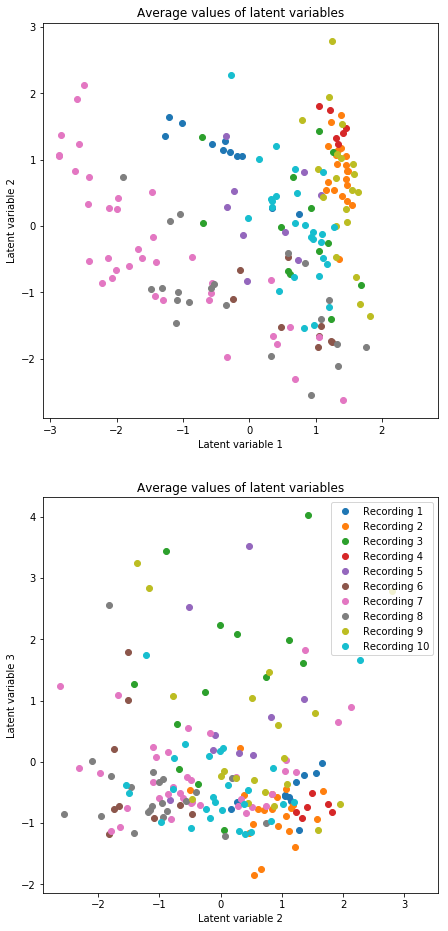

In [56]:
plt.figure(figsize=(8, 16))
for cellnum in range(1, 11):
    files = glob.glob(("spikefinder.train.longrange/"
                       "train.%d.*32.cpkl" % cellnum))

    xs = []
    for file_ in files:
        with open(file_, 'r') as f:
            dat = pickle.load(f)
            x = dat.mean(axis = 0)
            xs.append(x)
    X = np.array(xs)
    plt.subplot(211)
    plt.plot(X[:, 0], X[:, 1], 'o')
    plt.subplot(212)
    plt.plot(X[:, 1], X[:, 2], 'o')
      
plt.subplot(211)
#plt.legend(["Recording %d" % x for x in range(1, 11)])
plt.axis('square')
plt.xlabel('Latent variable 1')
plt.ylabel('Latent variable 2')
plt.title('Average values of latent variables')

plt.subplot(212)
plt.legend(["Recording %d" % x for x in range(1, 11)])
plt.axis('square')
plt.xlabel('Latent variable 2')
plt.ylabel('Latent variable 3')
plt.title('Average values of latent variables')

Why are the latent variables computed per minibatch rather than per neuron? There's only 173 neurons in the training set, which means the inference network would have to learn to adapt itself based on very few examplars. However, we can assume that the statistics of the calcium traces are reflected in every short snippet (minibatch) of these calcium traces. There are many more minibatches than neurons (~100X), so the ResNet can learn a more complex function of the calcium trace statistics.

# Inference with Resnet

We learn a ResNet with 7 intermediate layers that maps calcium traces to infered spike rates. The first layer uses an attention mechanism to select which filters to use based on the latent variables learned by the mixture density network. This output is passed through 7 residual convolutional layers. Finally, the output of these residual layers is fed to a RelU nonlinearity for the final prediction. We use a scaled squared error loss; the scaling is set such that the loss is proportional to the square of the cosine distance.

Learn the model like so:

In [51]:
!python train_resnet.py --model_name=universal_resnet

INFO:tensorflow:Computing features for neuron num 0, 0
INFO:tensorflow:Computing features for neuron num 0, 1
INFO:tensorflow:Computing features for neuron num 0, 2
INFO:tensorflow:Computing features for neuron num 0, 3
INFO:tensorflow:Computing features for neuron num 0, 4
INFO:tensorflow:Computing features for neuron num 0, 5
INFO:tensorflow:Computing features for neuron num 0, 6
INFO:tensorflow:Computing features for neuron num 0, 7
INFO:tensorflow:Computing features for neuron num 0, 8
INFO:tensorflow:Computing features for neuron num 0, 9
INFO:tensorflow:Computing features for neuron num 0, 10
INFO:tensorflow:Computing features for neuron num 1, 0
INFO:tensorflow:Computing features for neuron num 1, 1
INFO:tensorflow:Computing features for neuron num 1, 2
INFO:tensorflow:Computing features for neuron num 1, 3
INFO:tensorflow:Computing features for neuron num 1, 4
INFO:tensorflow:Computing features for neuron num 1, 5
INFO:tensorflow:Computing features for neuron num 1, 6
INFO:tens

INFO:tensorflow:Computing features for neuron num 9, 2
INFO:tensorflow:Computing features for neuron num 9, 3
INFO:tensorflow:Computing features for neuron num 9, 4
INFO:tensorflow:Computing features for neuron num 9, 5
INFO:tensorflow:Computing features for neuron num 9, 6
INFO:tensorflow:Computing features for neuron num 9, 7
INFO:tensorflow:Computing features for neuron num 9, 8
INFO:tensorflow:Computing features for neuron num 9, 9
INFO:tensorflow:Computing features for neuron num 9, 10
INFO:tensorflow:Computing features for neuron num 9, 11
INFO:tensorflow:Computing features for neuron num 9, 12
INFO:tensorflow:Computing features for neuron num 9, 13
INFO:tensorflow:Computing features for neuron num 9, 14
INFO:tensorflow:Computing features for neuron num 9, 15
INFO:tensorflow:Computing features for neuron num 9, 16
INFO:tensorflow:Computing features for neuron num 9, 17
INFO:tensorflow:Computing features for neuron num 9, 18
INFO:tensorflow:Computing features for neuron num 9, 19


INFO:tensorflow:global_step/sec: 57.9418
INFO:tensorflow:loss = 1.20808, step = 157901 (1.726 sec)
INFO:tensorflow:global_step/sec: 56.605
INFO:tensorflow:loss = 0.866872, step = 158001 (1.767 sec)
INFO:tensorflow:zero_fraction_tracker = 0.925781, relu_coarse = [0 0 0 ..., 0 0 0] (3.492 sec)
INFO:tensorflow:global_step/sec: 58.5927
INFO:tensorflow:loss = 0.81668, step = 158101 (1.707 sec)
INFO:tensorflow:global_step/sec: 58.5452
INFO:tensorflow:loss = 0.805159, step = 158201 (1.708 sec)
INFO:tensorflow:zero_fraction_tracker = 0.898804, relu_coarse = [0 0 0 ..., 0 0 0] (3.415 sec)
INFO:tensorflow:global_step/sec: 58.7383
INFO:tensorflow:loss = 0.905049, step = 158301 (1.703 sec)
INFO:tensorflow:global_step/sec: 57.5427
INFO:tensorflow:loss = 0.646098, step = 158401 (1.738 sec)
INFO:tensorflow:zero_fraction_tracker = 0.894775, relu_coarse = [0 0 0 ..., 0 0 0] (3.441 sec)
INFO:tensorflow:global_step/sec: 57.1716
INFO:tensorflow:loss = 0.918777, step = 158501 (1.749 sec)
INFO:tensorflow:gl

INFO:tensorflow:global_step/sec: 58.5187
INFO:tensorflow:loss = 0.500426, step = 162601 (1.709 sec)
INFO:tensorflow:zero_fraction_tracker = 0.917236, relu_coarse = [0 0 0 ..., 0 0 0] (3.448 sec)
INFO:tensorflow:global_step/sec: 57.3296
INFO:tensorflow:loss = 0.839931, step = 162701 (1.744 sec)
INFO:tensorflow:Saving checkpoints for 162731 into universal_resnet/model.ckpt.
INFO:tensorflow:global_step/sec: 47.2121
INFO:tensorflow:loss = 1.10186, step = 162801 (2.118 sec)
INFO:tensorflow:zero_fraction_tracker = 0.912842, relu_coarse = [151  79  55 ...,   0   0   0] (3.862 sec)
INFO:tensorflow:global_step/sec: 57.8381
INFO:tensorflow:loss = 0.598253, step = 162901 (1.729 sec)
INFO:tensorflow:global_step/sec: 59.7883
INFO:tensorflow:loss = 0.592796, step = 163001 (1.673 sec)
INFO:tensorflow:zero_fraction_tracker = 0.901367, relu_coarse = [0 0 0 ..., 0 0 0] (3.401 sec)
INFO:tensorflow:global_step/sec: 59.315
INFO:tensorflow:loss = 0.572243, step = 163101 (1.686 sec)
INFO:tensorflow:global_st

INFO:tensorflow:global_step/sec: 58.1089
INFO:tensorflow:loss = 0.675381, step = 167301 (1.720 sec)
INFO:tensorflow:global_step/sec: 57.3547
INFO:tensorflow:loss = 0.885001, step = 167401 (1.743 sec)
INFO:tensorflow:zero_fraction_tracker = 0.911011, relu_coarse = [2049 2387 1987 ...,    0    0    0] (3.464 sec)
INFO:tensorflow:global_step/sec: 57.8398
INFO:tensorflow:loss = 0.542391, step = 167501 (1.729 sec)
INFO:tensorflow:global_step/sec: 58.1247
INFO:tensorflow:loss = 1.89154, step = 167601 (1.721 sec)
INFO:tensorflow:zero_fraction_tracker = 0.894165, relu_coarse = [0 0 0 ..., 0 0 0] (3.450 sec)
INFO:tensorflow:global_step/sec: 55.988
INFO:tensorflow:loss = 0.831638, step = 167701 (1.787 sec)
INFO:tensorflow:global_step/sec: 57.712
INFO:tensorflow:loss = 0.843668, step = 167801 (1.732 sec)
INFO:tensorflow:zero_fraction_tracker = 0.895264, relu_coarse = [0 0 0 ..., 0 0 0] (3.519 sec)
INFO:tensorflow:global_step/sec: 56.6082
INFO:tensorflow:loss = 0.466249, step = 167901 (1.767 sec)


INFO:tensorflow:global_step/sec: 56.1433
INFO:tensorflow:loss = 0.853113, step = 171201 (1.781 sec)
INFO:tensorflow:zero_fraction_tracker = 0.919678, relu_coarse = [  0   0   0 ...,   0 146 209] (3.561 sec)
INFO:tensorflow:global_step/sec: 57.7813
INFO:tensorflow:loss = 0.521968, step = 171301 (1.731 sec)
INFO:tensorflow:global_step/sec: 60.2835
INFO:tensorflow:loss = 0.99472, step = 171401 (1.659 sec)
INFO:tensorflow:zero_fraction_tracker = 0.875366, relu_coarse = [644 659 640 ...,   0   0   0] (3.389 sec)
INFO:tensorflow:global_step/sec: 58.0267
INFO:tensorflow:loss = 1.08438, step = 171501 (1.723 sec)
INFO:tensorflow:global_step/sec: 60.0075
INFO:tensorflow:loss = 0.812557, step = 171601 (1.667 sec)
INFO:tensorflow:zero_fraction_tracker = 0.891846, relu_coarse = [0 0 0 ..., 0 0 0] (3.390 sec)
INFO:tensorflow:global_step/sec: 58.9453
INFO:tensorflow:loss = 0.778408, step = 171701 (1.696 sec)
INFO:tensorflow:global_step/sec: 57.0395
INFO:tensorflow:loss = 0.479879, step = 171801 (1.75

INFO:tensorflow:global_step/sec: 57.7514
INFO:tensorflow:loss = 0.563078, step = 175901 (1.731 sec)
INFO:tensorflow:global_step/sec: 57.1564
INFO:tensorflow:loss = 0.908735, step = 176001 (1.750 sec)
INFO:tensorflow:zero_fraction_tracker = 0.902954, relu_coarse = [  0 225 379 ...,   0   0   0] (3.481 sec)
INFO:tensorflow:global_step/sec: 58.0049
INFO:tensorflow:loss = 1.18795, step = 176101 (1.724 sec)
INFO:tensorflow:Saving checkpoints for 176140 into universal_resnet/model.ckpt.
INFO:tensorflow:global_step/sec: 45.252
INFO:tensorflow:loss = 1.04107, step = 176201 (2.210 sec)
INFO:tensorflow:zero_fraction_tracker = 0.892944, relu_coarse = [0 0 0 ..., 0 0 0] (3.934 sec)
INFO:tensorflow:global_step/sec: 58.4197
INFO:tensorflow:loss = 0.647998, step = 176301 (1.712 sec)
INFO:tensorflow:global_step/sec: 58.4669
INFO:tensorflow:loss = 0.974213, step = 176401 (1.711 sec)
INFO:tensorflow:zero_fraction_tracker = 0.901245, relu_coarse = [0 0 0 ..., 0 0 0] (3.422 sec)
INFO:tensorflow:global_ste

INFO:tensorflow:Saving dict for global step 179487: global_step = 179487, loss = 0.887947, mse = 0.00320535
INFO:tensorflow:Validation (step 180001): loss = 0.887947, mse = 0.00320535, global_step = 179487
INFO:tensorflow:global_step/sec: 30.28
INFO:tensorflow:loss = 0.606539, step = 180101 (3.302 sec)
INFO:tensorflow:global_step/sec: 58.0505
INFO:tensorflow:loss = 0.848645, step = 180201 (1.723 sec)
INFO:tensorflow:zero_fraction_tracker = 0.870972, relu_coarse = [215 134 102 ...,   0   0   0] (5.024 sec)
INFO:tensorflow:global_step/sec: 58.444
INFO:tensorflow:loss = 0.758751, step = 180301 (1.711 sec)
INFO:tensorflow:global_step/sec: 58.0856
INFO:tensorflow:loss = 1.00712, step = 180401 (1.722 sec)
INFO:tensorflow:zero_fraction_tracker = 0.90332, relu_coarse = [ 0  0  0 ..., 21  0  0] (3.433 sec)
INFO:tensorflow:global_step/sec: 56.7562
INFO:tensorflow:loss = 0.790955, step = 180501 (1.762 sec)
INFO:tensorflow:global_step/sec: 57.8022
INFO:tensorflow:loss = 0.274246, step = 180601 (1.

INFO:tensorflow:global_step/sec: 58.7436
INFO:tensorflow:loss = 0.473974, step = 184601 (1.703 sec)
INFO:tensorflow:zero_fraction_tracker = 0.891113, relu_coarse = [0 0 0 ..., 0 0 0] (3.426 sec)
INFO:tensorflow:global_step/sec: 58.9212
INFO:tensorflow:loss = 0.753447, step = 184701 (1.697 sec)
INFO:tensorflow:global_step/sec: 57.8239
INFO:tensorflow:loss = 0.826782, step = 184801 (1.729 sec)
INFO:tensorflow:zero_fraction_tracker = 0.892334, relu_coarse = [0 0 0 ..., 0 0 0] (3.426 sec)
INFO:tensorflow:global_step/sec: 59.2616
INFO:tensorflow:loss = 0.585332, step = 184901 (1.688 sec)
INFO:tensorflow:global_step/sec: 56.7992
INFO:tensorflow:loss = 0.612116, step = 185001 (1.760 sec)
INFO:tensorflow:zero_fraction_tracker = 0.888428, relu_coarse = [  0   0   0 ..., 126   0   0] (3.448 sec)
INFO:tensorflow:global_step/sec: 57.3372
INFO:tensorflow:loss = 0.473169, step = 185101 (1.744 sec)
INFO:tensorflow:global_step/sec: 57.5362
INFO:tensorflow:loss = 0.989883, step = 185201 (1.738 sec)
INF

INFO:tensorflow:global_step/sec: 57.8169
INFO:tensorflow:loss = 0.699773, step = 189201 (1.730 sec)
INFO:tensorflow:zero_fraction_tracker = 0.911133, relu_coarse = [0 0 0 ..., 0 0 0] (3.450 sec)
INFO:tensorflow:global_step/sec: 61.1599
INFO:tensorflow:loss = 0.618367, step = 189301 (1.635 sec)
INFO:tensorflow:global_step/sec: 57.5877
INFO:tensorflow:loss = 0.576705, step = 189401 (1.737 sec)
INFO:tensorflow:zero_fraction_tracker = 0.900757, relu_coarse = [0 0 0 ..., 0 0 0] (3.371 sec)
INFO:tensorflow:global_step/sec: 59.1375
INFO:tensorflow:loss = 0.719599, step = 189501 (1.691 sec)
INFO:tensorflow:Saving checkpoints for 189536 into universal_resnet/model.ckpt.
INFO:tensorflow:global_step/sec: 49.2617
INFO:tensorflow:loss = 0.652935, step = 189601 (2.030 sec)
INFO:tensorflow:zero_fraction_tracker = 0.913818, relu_coarse = [232 108   0 ...,   0   0   0] (3.721 sec)
INFO:tensorflow:global_step/sec: 57.2764
INFO:tensorflow:loss = 0.89565, step = 189701 (1.746 sec)
INFO:tensorflow:global_s

INFO:tensorflow:global_step/sec: 59.1606
INFO:tensorflow:loss = 1.14748, step = 193701 (1.690 sec)
INFO:tensorflow:global_step/sec: 57.6562
INFO:tensorflow:loss = 1.09, step = 193801 (1.735 sec)
INFO:tensorflow:zero_fraction_tracker = 0.889526, relu_coarse = [0 0 0 ..., 0 0 0] (3.425 sec)
INFO:tensorflow:global_step/sec: 58.9066
INFO:tensorflow:loss = 1.29071, step = 193901 (1.697 sec)
INFO:tensorflow:global_step/sec: 58.7429
INFO:tensorflow:loss = 0.588693, step = 194001 (1.702 sec)
INFO:tensorflow:zero_fraction_tracker = 0.883423, relu_coarse = [0 0 0 ..., 0 0 0] (3.400 sec)
INFO:tensorflow:Starting evaluation at 2018-01-18-05:27:40
2018-01-17 21:27:40.922089: I tensorflow/core/common_runtime/gpu/gpu_device.cc:977] Creating TensorFlow device (/gpu:0) -> (device: 0, name: TITAN X (Pascal), pci bus id: 0000:01:00.0)
INFO:tensorflow:Restoring parameters from universal_resnet/model.ckpt-192869
2018-01-17 21:27:41.748990: W tensorflow/core/framework/op_kernel.cc:1152] Out of range: FIFOQu

2018-01-17 21:28:53.689530: W tensorflow/core/framework/op_kernel.cc:1152] Out of range: FIFOQueue '_13_enqueue_input/fifo_queue' is closed and has insufficient elements (requested 128, current size 0)
	 [[Node: fifo_queue_DequeueUpTo = QueueDequeueUpToV2[component_types=[DT_INT64, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_INT32, DT_INT64, DT_INT64, DT_FLOAT, DT_FLOAT, DT_FLOAT], timeout_ms=-1, _device="/job:localhost/replica:0/task:0/cpu:0"](enqueue_input/fifo_queue, fifo_queue_DequeueUpTo/n)]]
INFO:tensorflow:Finished evaluation at 2018-01-18-05:28:53
INFO:tensorflow:Saving dict for global step 196205: global_step = 196205, loss = 0.886015, mse = 0.00319837
INFO:tensorflow:Validation (step 198001): loss = 0.886015, mse = 0.00319837, global_step = 196205
INFO:tensorflow:global_step/sec: 30.2255
INFO:tensorflow:loss = 1.94037, step = 198101 (3.308

INFO:tensorflow:global_step/sec: 56.1059
INFO:tensorflow:loss = 0.754505, step = 202101 (1.782 sec)
INFO:tensorflow:global_step/sec: 57.317
INFO:tensorflow:loss = 0.466411, step = 202201 (1.745 sec)
INFO:tensorflow:zero_fraction_tracker = 0.902588, relu_coarse = [0 0 0 ..., 0 0 0] (3.528 sec)
INFO:tensorflow:global_step/sec: 56.9193
INFO:tensorflow:loss = 0.743824, step = 202301 (1.757 sec)
INFO:tensorflow:global_step/sec: 58.2595
INFO:tensorflow:loss = 1.32427, step = 202401 (1.717 sec)
INFO:tensorflow:zero_fraction_tracker = 0.89563, relu_coarse = [ 199    0    0 ...,  611  958 1028] (3.473 sec)
INFO:tensorflow:global_step/sec: 56.2411
INFO:tensorflow:loss = 0.89613, step = 202501 (1.778 sec)
INFO:tensorflow:global_step/sec: 59.4513
INFO:tensorflow:loss = 0.602721, step = 202601 (1.682 sec)
INFO:tensorflow:zero_fraction_tracker = 0.874023, relu_coarse = [0 0 0 ..., 0 0 0] (3.461 sec)
INFO:tensorflow:global_step/sec: 55.5221
INFO:tensorflow:loss = 0.700204, step = 202701 (1.801 sec)
I

INFO:tensorflow:global_step/sec: 58.0157
INFO:tensorflow:loss = 0.857425, step = 206701 (1.723 sec)
INFO:tensorflow:global_step/sec: 56.5237
INFO:tensorflow:loss = 0.74646, step = 206801 (1.769 sec)
INFO:tensorflow:zero_fraction_tracker = 0.887695, relu_coarse = [0 0 0 ..., 0 0 0] (3.492 sec)
INFO:tensorflow:global_step/sec: 58.1766
INFO:tensorflow:loss = 0.477025, step = 206901 (1.719 sec)
INFO:tensorflow:global_step/sec: 58.4998
INFO:tensorflow:loss = 0.797849, step = 207001 (1.710 sec)
INFO:tensorflow:zero_fraction_tracker = 0.889771, relu_coarse = [0 0 0 ..., 0 0 0] (3.429 sec)
INFO:tensorflow:global_step/sec: 57.7189
INFO:tensorflow:loss = 1.19721, step = 207101 (1.732 sec)
INFO:tensorflow:global_step/sec: 58.1123
INFO:tensorflow:loss = 0.534102, step = 207201 (1.721 sec)
INFO:tensorflow:zero_fraction_tracker = 0.873535, relu_coarse = [0 0 0 ..., 0 0 0] (3.453 sec)
INFO:tensorflow:global_step/sec: 57.6204
INFO:tensorflow:loss = 0.817623, step = 207301 (1.736 sec)
INFO:tensorflow:g

INFO:tensorflow:global_step/sec: 57.1759
INFO:tensorflow:loss = 1.7319, step = 210401 (1.749 sec)
INFO:tensorflow:zero_fraction_tracker = 0.881836, relu_coarse = [0 0 0 ..., 0 0 0] (3.494 sec)
INFO:tensorflow:global_step/sec: 56.6218
INFO:tensorflow:loss = 0.651818, step = 210501 (1.766 sec)
INFO:tensorflow:global_step/sec: 58.0739
INFO:tensorflow:loss = 1.09533, step = 210601 (1.722 sec)
INFO:tensorflow:zero_fraction_tracker = 0.880615, relu_coarse = [0 0 0 ..., 0 0 0] (3.488 sec)
INFO:tensorflow:global_step/sec: 57.6067
INFO:tensorflow:loss = 0.445912, step = 210701 (1.736 sec)
INFO:tensorflow:global_step/sec: 57.7576
INFO:tensorflow:loss = 0.769263, step = 210801 (1.731 sec)
INFO:tensorflow:zero_fraction_tracker = 0.891602, relu_coarse = [ 0 46 98 ...,  0  0  0] (3.467 sec)
INFO:tensorflow:global_step/sec: 58.3125
INFO:tensorflow:loss = 0.61551, step = 210901 (1.715 sec)
INFO:tensorflow:global_step/sec: 55.8818
INFO:tensorflow:loss = 0.57416, step = 211001 (1.790 sec)
INFO:tensorflo

INFO:tensorflow:loss = 1.16066, step = 214901 (1.738 sec)
INFO:tensorflow:global_step/sec: 57.4697
INFO:tensorflow:loss = 1.02961, step = 215001 (1.739 sec)
INFO:tensorflow:zero_fraction_tracker = 0.91333, relu_coarse = [0 0 0 ..., 0 0 0] (3.477 sec)
INFO:tensorflow:global_step/sec: 57.7411
INFO:tensorflow:loss = 0.872551, step = 215101 (1.732 sec)
INFO:tensorflow:global_step/sec: 58.0477
INFO:tensorflow:loss = 1.17029, step = 215201 (1.723 sec)
INFO:tensorflow:zero_fraction_tracker = 0.897949, relu_coarse = [0 0 0 ..., 0 0 0] (3.455 sec)
INFO:tensorflow:global_step/sec: 57.4407
INFO:tensorflow:loss = 0.804222, step = 215301 (1.741 sec)
INFO:tensorflow:global_step/sec: 57.1581
INFO:tensorflow:loss = 0.571108, step = 215401 (1.750 sec)
INFO:tensorflow:zero_fraction_tracker = 0.88623, relu_coarse = [0 0 0 ..., 0 0 0] (3.491 sec)
INFO:tensorflow:global_step/sec: 57.3553
INFO:tensorflow:loss = 0.572732, step = 215501 (1.743 sec)
INFO:tensorflow:global_step/sec: 57.5857
INFO:tensorflow:loss

INFO:tensorflow:global_step/sec: 58.7902
INFO:tensorflow:loss = 0.707747, step = 219501 (1.701 sec)
INFO:tensorflow:Saving checkpoints for 219594 into universal_resnet/model.ckpt.
INFO:tensorflow:global_step/sec: 46.5345
INFO:tensorflow:loss = 1.70588, step = 219601 (2.149 sec)
INFO:tensorflow:zero_fraction_tracker = 0.895386, relu_coarse = [0 0 0 ..., 0 0 0] (3.850 sec)
INFO:tensorflow:global_step/sec: 59.513
INFO:tensorflow:loss = 0.493822, step = 219701 (1.680 sec)
INFO:tensorflow:global_step/sec: 62.6753
INFO:tensorflow:loss = 0.549901, step = 219801 (1.596 sec)
INFO:tensorflow:zero_fraction_tracker = 0.895386, relu_coarse = [  0   0   0 ..., 484 708 578] (3.276 sec)
INFO:tensorflow:global_step/sec: 57.1889
INFO:tensorflow:loss = 0.620331, step = 219901 (1.748 sec)
INFO:tensorflow:global_step/sec: 58.6912
INFO:tensorflow:loss = 0.746108, step = 220001 (1.704 sec)
INFO:tensorflow:zero_fraction_tracker = 0.880493, relu_coarse = [0 0 0 ..., 0 0 0] (3.452 sec)
INFO:tensorflow:Starting 

INFO:tensorflow:global_step/sec: 59.0932
INFO:tensorflow:loss = 0.726222, step = 224001 (1.692 sec)
INFO:tensorflow:zero_fraction_tracker = 0.897217, relu_coarse = [0 0 0 ..., 0 0 0] (3.441 sec)
INFO:tensorflow:Starting evaluation at 2018-01-18-05:36:39
2018-01-17 21:36:39.303962: I tensorflow/core/common_runtime/gpu/gpu_device.cc:977] Creating TensorFlow device (/gpu:0) -> (device: 0, name: TITAN X (Pascal), pci bus id: 0000:01:00.0)
INFO:tensorflow:Restoring parameters from universal_resnet/model.ckpt-222971
2018-01-17 21:36:40.228453: W tensorflow/core/framework/op_kernel.cc:1152] Out of range: FIFOQueue '_21_enqueue_input/fifo_queue' is closed and has insufficient elements (requested 128, current size 0)
	 [[Node: fifo_queue_DequeueUpTo = QueueDequeueUpToV2[component_types=[DT_INT64, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, D

INFO:tensorflow:global_step/sec: 28.8426
INFO:tensorflow:loss = 0.822982, step = 228101 (3.467 sec)
INFO:tensorflow:global_step/sec: 57.3775
INFO:tensorflow:loss = 0.75879, step = 228201 (1.743 sec)
INFO:tensorflow:zero_fraction_tracker = 0.911377, relu_coarse = [0 0 0 ..., 0 0 0] (5.210 sec)
INFO:tensorflow:global_step/sec: 56.6277
INFO:tensorflow:loss = 1.00081, step = 228301 (1.765 sec)
INFO:tensorflow:global_step/sec: 57.3173
INFO:tensorflow:loss = 0.508127, step = 228401 (1.745 sec)
INFO:tensorflow:zero_fraction_tracker = 0.87561, relu_coarse = [0 0 0 ..., 0 0 0] (3.510 sec)
INFO:tensorflow:global_step/sec: 58.2278
INFO:tensorflow:loss = 0.981804, step = 228501 (1.717 sec)
INFO:tensorflow:global_step/sec: 57.6798
INFO:tensorflow:loss = 0.60071, step = 228601 (1.734 sec)
INFO:tensorflow:zero_fraction_tracker = 0.886719, relu_coarse = [0 0 0 ..., 0 0 0] (3.452 sec)
INFO:tensorflow:global_step/sec: 57.9605
INFO:tensorflow:loss = 0.791683, step = 228701 (1.725 sec)
INFO:tensorflow:glo

INFO:tensorflow:global_step/sec: 57.5766
INFO:tensorflow:loss = 0.8712, step = 232701 (1.737 sec)
INFO:tensorflow:global_step/sec: 57.9541
INFO:tensorflow:loss = 1.01263, step = 232801 (1.726 sec)
INFO:tensorflow:zero_fraction_tracker = 0.89978, relu_coarse = [0 0 0 ..., 0 0 0] (3.462 sec)
INFO:tensorflow:global_step/sec: 57.4437
INFO:tensorflow:loss = 0.796029, step = 232901 (1.741 sec)
INFO:tensorflow:Saving checkpoints for 232986 into universal_resnet/model.ckpt.
INFO:tensorflow:global_step/sec: 50.5296
INFO:tensorflow:loss = 0.814931, step = 233001 (1.979 sec)
INFO:tensorflow:zero_fraction_tracker = 0.891602, relu_coarse = [0 0 0 ..., 0 0 0] (3.720 sec)
INFO:tensorflow:global_step/sec: 57.8897
INFO:tensorflow:loss = 0.881139, step = 233101 (1.728 sec)
INFO:tensorflow:global_step/sec: 58.5972
INFO:tensorflow:loss = 0.458902, step = 233201 (1.706 sec)
INFO:tensorflow:zero_fraction_tracker = 0.884888, relu_coarse = [ 0  0  0 ..., 62  0  0] (3.434 sec)
INFO:tensorflow:global_step/sec: 

INFO:tensorflow:global_step/sec: 57.8408
INFO:tensorflow:loss = 0.902014, step = 237201 (1.728 sec)
INFO:tensorflow:zero_fraction_tracker = 0.864136, relu_coarse = [66  0  0 ...,  0  0  0] (3.471 sec)
INFO:tensorflow:global_step/sec: 57.7678
INFO:tensorflow:loss = 1.38347, step = 237301 (1.731 sec)
INFO:tensorflow:global_step/sec: 56.4423
INFO:tensorflow:loss = 1.14246, step = 237401 (1.772 sec)
INFO:tensorflow:zero_fraction_tracker = 0.884644, relu_coarse = [0 0 0 ..., 0 0 0] (3.503 sec)
INFO:tensorflow:global_step/sec: 56.4401
INFO:tensorflow:loss = 0.920841, step = 237501 (1.772 sec)
INFO:tensorflow:global_step/sec: 56.7107
INFO:tensorflow:loss = 0.485035, step = 237601 (1.764 sec)
INFO:tensorflow:zero_fraction_tracker = 0.933472, relu_coarse = [0 0 0 ..., 0 0 0] (3.536 sec)
INFO:tensorflow:global_step/sec: 56.8554
INFO:tensorflow:loss = 0.94213, step = 237701 (1.758 sec)
INFO:tensorflow:global_step/sec: 56.0033
INFO:tensorflow:loss = 0.546403, step = 237801 (1.786 sec)
INFO:tensorf

INFO:tensorflow:global_step/sec: 56.4233
INFO:tensorflow:loss = 1.31775, step = 240701 (1.772 sec)
INFO:tensorflow:global_step/sec: 58.678
INFO:tensorflow:loss = 1.59865, step = 240801 (1.704 sec)
INFO:tensorflow:zero_fraction_tracker = 0.875732, relu_coarse = [0 0 0 ..., 0 0 0] (3.476 sec)
INFO:tensorflow:global_step/sec: 58.3505
INFO:tensorflow:loss = 1.81984, step = 240901 (1.714 sec)
INFO:tensorflow:global_step/sec: 56.5254
INFO:tensorflow:loss = 0.843482, step = 241001 (1.770 sec)
INFO:tensorflow:zero_fraction_tracker = 0.857056, relu_coarse = [0 0 0 ..., 0 0 0] (3.484 sec)
INFO:tensorflow:global_step/sec: 58.4487
INFO:tensorflow:loss = 0.492143, step = 241101 (1.711 sec)
INFO:tensorflow:global_step/sec: 56.7701
INFO:tensorflow:loss = 0.933551, step = 241201 (1.761 sec)
INFO:tensorflow:zero_fraction_tracker = 0.892578, relu_coarse = [0 0 0 ..., 0 0 0] (3.472 sec)
INFO:tensorflow:global_step/sec: 57.9784
INFO:tensorflow:loss = 1.08038, step = 241301 (1.725 sec)
INFO:tensorflow:glob

INFO:tensorflow:global_step/sec: 57.2818
INFO:tensorflow:loss = 0.890215, step = 245301 (1.745 sec)
INFO:tensorflow:global_step/sec: 56.2891
INFO:tensorflow:loss = 0.664108, step = 245401 (1.777 sec)
INFO:tensorflow:zero_fraction_tracker = 0.880493, relu_coarse = [0 0 0 ..., 0 0 0] (3.522 sec)
INFO:tensorflow:global_step/sec: 55.9188
INFO:tensorflow:loss = 0.675988, step = 245501 (1.789 sec)
INFO:tensorflow:global_step/sec: 57.3447
INFO:tensorflow:loss = 0.675898, step = 245601 (1.744 sec)
INFO:tensorflow:zero_fraction_tracker = 0.898682, relu_coarse = [  0   0   0 ..., 109   0   0] (3.532 sec)
INFO:tensorflow:global_step/sec: 57.5595
INFO:tensorflow:loss = 0.599615, step = 245701 (1.737 sec)
INFO:tensorflow:global_step/sec: 57.6417
INFO:tensorflow:loss = 0.760804, step = 245801 (1.735 sec)
INFO:tensorflow:zero_fraction_tracker = 0.892578, relu_coarse = [0 0 0 ..., 0 0 0] (3.472 sec)
INFO:tensorflow:global_step/sec: 57.0123
INFO:tensorflow:loss = 0.973622, step = 245901 (1.754 sec)
INF

INFO:tensorflow:global_step/sec: 57.4839
INFO:tensorflow:loss = 0.954946, step = 249801 (1.740 sec)
INFO:tensorflow:zero_fraction_tracker = 0.882935, relu_coarse = [0 0 0 ..., 0 0 0] (3.894 sec)
INFO:tensorflow:global_step/sec: 57.0292
INFO:tensorflow:loss = 1.10937, step = 249901 (1.754 sec)
INFO:tensorflow:global_step/sec: 57.4793
INFO:tensorflow:loss = 0.793936, step = 250001 (1.740 sec)
INFO:tensorflow:zero_fraction_tracker = 0.876343, relu_coarse = [382 355 308 ...,   0   0   0] (3.494 sec)
INFO:tensorflow:Starting evaluation at 2018-01-18-05:44:26
2018-01-17 21:44:27.177548: I tensorflow/core/common_runtime/gpu/gpu_device.cc:977] Creating TensorFlow device (/gpu:0) -> (device: 0, name: TITAN X (Pascal), pci bus id: 0000:01:00.0)
INFO:tensorflow:Restoring parameters from universal_resnet/model.ckpt-249679
INFO:tensorflow:Finished evaluation at 2018-01-18-05:44:28
INFO:tensorflow:Saving dict for global step 249679: global_step = 249679, loss = 0.879518, mse = 0.0031749
INFO:tensorf

INFO:tensorflow:global_step/sec: 27.5494
INFO:tensorflow:loss = 0.922396, step = 254101 (3.630 sec)
INFO:tensorflow:global_step/sec: 57.9825
INFO:tensorflow:loss = 0.570783, step = 254201 (1.725 sec)
INFO:tensorflow:zero_fraction_tracker = 0.883545, relu_coarse = [0 0 0 ..., 0 0 0] (5.354 sec)
INFO:tensorflow:global_step/sec: 57.2883
INFO:tensorflow:loss = 0.457164, step = 254301 (1.746 sec)
INFO:tensorflow:global_step/sec: 57.8584
INFO:tensorflow:loss = 1.02023, step = 254401 (1.728 sec)
INFO:tensorflow:zero_fraction_tracker = 0.882935, relu_coarse = [0 0 0 ..., 0 0 0] (3.474 sec)
INFO:tensorflow:global_step/sec: 57.1791
INFO:tensorflow:loss = 0.614681, step = 254501 (1.749 sec)
INFO:tensorflow:global_step/sec: 56.4457
INFO:tensorflow:loss = 0.603114, step = 254601 (1.772 sec)
INFO:tensorflow:zero_fraction_tracker = 0.887207, relu_coarse = [  0  54   0 ..., 414   0 560] (3.521 sec)
INFO:tensorflow:global_step/sec: 58.1797
INFO:tensorflow:loss = 0.789298, step = 254701 (1.719 sec)
INFO

INFO:tensorflow:global_step/sec: 57.276
INFO:tensorflow:loss = 0.825516, step = 258601 (1.746 sec)
INFO:tensorflow:zero_fraction_tracker = 0.883179, relu_coarse = [0 0 0 ..., 0 0 0] (3.424 sec)
INFO:tensorflow:global_step/sec: 56.9415
INFO:tensorflow:loss = 0.685752, step = 258701 (1.756 sec)
INFO:tensorflow:global_step/sec: 58.4884
INFO:tensorflow:loss = 0.76954, step = 258801 (1.710 sec)
INFO:tensorflow:zero_fraction_tracker = 0.881348, relu_coarse = [  0   0   0 ..., 277   0 112] (3.465 sec)
INFO:tensorflow:global_step/sec: 57.0377
INFO:tensorflow:loss = 0.956455, step = 258901 (1.753 sec)
INFO:tensorflow:global_step/sec: 56.2879
INFO:tensorflow:loss = 0.637396, step = 259001 (1.777 sec)
INFO:tensorflow:zero_fraction_tracker = 0.890015, relu_coarse = [0 0 0 ..., 0 0 0] (3.530 sec)
INFO:tensorflow:global_step/sec: 58.7317
INFO:tensorflow:loss = 0.608725, step = 259101 (1.703 sec)
INFO:tensorflow:global_step/sec: 57.7527
INFO:tensorflow:loss = 0.360952, step = 259201 (1.732 sec)
INFO:

INFO:tensorflow:global_step/sec: 47.1728
INFO:tensorflow:loss = 0.767, step = 263001 (2.120 sec)
INFO:tensorflow:zero_fraction_tracker = 0.906738, relu_coarse = [0 0 0 ..., 0 0 0] (3.876 sec)
INFO:tensorflow:global_step/sec: 56.2654
INFO:tensorflow:loss = 0.816625, step = 263101 (1.777 sec)
INFO:tensorflow:global_step/sec: 57.3863
INFO:tensorflow:loss = 0.483214, step = 263201 (1.742 sec)
INFO:tensorflow:zero_fraction_tracker = 0.886963, relu_coarse = [0 0 0 ..., 0 0 0] (3.520 sec)
INFO:tensorflow:global_step/sec: 56.1846
INFO:tensorflow:loss = 0.560639, step = 263301 (1.780 sec)
INFO:tensorflow:global_step/sec: 57.8683
INFO:tensorflow:loss = 0.644117, step = 263401 (1.728 sec)
INFO:tensorflow:zero_fraction_tracker = 0.896729, relu_coarse = [0 0 0 ..., 0 0 0] (3.508 sec)
INFO:tensorflow:global_step/sec: 56.9123
INFO:tensorflow:loss = 0.472503, step = 263501 (1.757 sec)
INFO:tensorflow:global_step/sec: 57.0206
INFO:tensorflow:loss = 0.570246, step = 263601 (1.754 sec)
INFO:tensorflow:ze

INFO:tensorflow:global_step/sec: 58.1348
INFO:tensorflow:loss = 0.847051, step = 267501 (1.720 sec)
INFO:tensorflow:global_step/sec: 58.7154
INFO:tensorflow:loss = 0.57076, step = 267601 (1.703 sec)
INFO:tensorflow:zero_fraction_tracker = 0.876221, relu_coarse = [1810 1386  988 ...,    0    0    0] (3.424 sec)
INFO:tensorflow:global_step/sec: 58.6527
INFO:tensorflow:loss = 0.605444, step = 267701 (1.705 sec)
INFO:tensorflow:global_step/sec: 56.586
INFO:tensorflow:loss = 0.633731, step = 267801 (1.767 sec)
INFO:tensorflow:zero_fraction_tracker = 0.894287, relu_coarse = [   0    0    0 ...,  996  959 1488] (3.472 sec)
INFO:tensorflow:global_step/sec: 58.6962
INFO:tensorflow:loss = 1.18076, step = 267901 (1.704 sec)
INFO:tensorflow:global_step/sec: 57.9496
INFO:tensorflow:loss = 0.86244, step = 268001 (1.725 sec)
INFO:tensorflow:zero_fraction_tracker = 0.887207, relu_coarse = [  0   0 806 ...,   0   0   0] (3.429 sec)
INFO:tensorflow:Starting evaluation at 2018-01-18-05:49:50
2018-01-17 2

INFO:tensorflow:global_step/sec: 58.8564
INFO:tensorflow:loss = 1.20477, step = 270901 (1.699 sec)
INFO:tensorflow:global_step/sec: 56.6717
INFO:tensorflow:loss = 0.691351, step = 271001 (1.765 sec)
INFO:tensorflow:zero_fraction_tracker = 0.911377, relu_coarse = [0 0 0 ..., 0 0 0] (3.464 sec)
INFO:tensorflow:global_step/sec: 57.1139
INFO:tensorflow:loss = 1.03831, step = 271101 (1.751 sec)
INFO:tensorflow:global_step/sec: 57.0596
INFO:tensorflow:loss = 0.637549, step = 271201 (1.752 sec)
INFO:tensorflow:zero_fraction_tracker = 0.880249, relu_coarse = [ 0  0  0 ..., 41 30  0] (3.503 sec)
INFO:tensorflow:global_step/sec: 56.8969
INFO:tensorflow:loss = 0.864612, step = 271301 (1.758 sec)
INFO:tensorflow:global_step/sec: 57.4508
INFO:tensorflow:loss = 0.583481, step = 271401 (1.741 sec)
INFO:tensorflow:zero_fraction_tracker = 0.884521, relu_coarse = [0 0 0 ..., 0 0 0] (3.499 sec)
INFO:tensorflow:global_step/sec: 56.7614
INFO:tensorflow:loss = 0.805653, step = 271501 (1.762 sec)
INFO:tensor

INFO:tensorflow:global_step/sec: 57.0318
INFO:tensorflow:loss = 0.836625, step = 275401 (1.753 sec)
INFO:tensorflow:zero_fraction_tracker = 0.905396, relu_coarse = [  0   0   0 ..., 352 384 439] (3.436 sec)
INFO:tensorflow:global_step/sec: 57.2851
INFO:tensorflow:loss = 0.945081, step = 275501 (1.746 sec)
INFO:tensorflow:global_step/sec: 58.553
INFO:tensorflow:loss = 0.805176, step = 275601 (1.708 sec)
INFO:tensorflow:zero_fraction_tracker = 0.887207, relu_coarse = [  0   0   0 ...,   0 138   0] (3.454 sec)
INFO:tensorflow:global_step/sec: 57.9545
INFO:tensorflow:loss = 0.714655, step = 275701 (1.726 sec)
INFO:tensorflow:global_step/sec: 57.7165
INFO:tensorflow:loss = 0.811318, step = 275801 (1.732 sec)
INFO:tensorflow:zero_fraction_tracker = 0.88623, relu_coarse = [0 0 0 ..., 0 0 0] (3.458 sec)
INFO:tensorflow:global_step/sec: 58.263
INFO:tensorflow:loss = 0.846306, step = 275901 (1.716 sec)
INFO:tensorflow:global_step/sec: 57.6945
INFO:tensorflow:loss = 0.474178, step = 276001 (1.733

INFO:tensorflow:global_step/sec: 47.4195
INFO:tensorflow:loss = 0.757595, step = 279701 (2.109 sec)
INFO:tensorflow:global_step/sec: 57.3132
INFO:tensorflow:loss = 0.708306, step = 279801 (1.745 sec)
INFO:tensorflow:zero_fraction_tracker = 0.874512, relu_coarse = [0 0 0 ..., 0 0 0] (3.854 sec)
INFO:tensorflow:global_step/sec: 58.4989
INFO:tensorflow:loss = 0.403679, step = 279901 (1.709 sec)
INFO:tensorflow:global_step/sec: 56.9841
INFO:tensorflow:loss = 0.849432, step = 280001 (1.755 sec)
INFO:tensorflow:zero_fraction_tracker = 0.874268, relu_coarse = [  0   0   0 ..., 245 243  39] (3.464 sec)
INFO:tensorflow:Starting evaluation at 2018-01-18-05:53:27
2018-01-17 21:53:27.729143: I tensorflow/core/common_runtime/gpu/gpu_device.cc:977] Creating TensorFlow device (/gpu:0) -> (device: 0, name: TITAN X (Pascal), pci bus id: 0000:01:00.0)
INFO:tensorflow:Restoring parameters from universal_resnet/model.ckpt-279646
2018-01-17 21:53:28.971655: W tensorflow/core/framework/op_kernel.cc:1152] Ou

INFO:tensorflow:Starting evaluation at 2018-01-18-05:54:39
2018-01-17 21:54:39.579384: I tensorflow/core/common_runtime/gpu/gpu_device.cc:977] Creating TensorFlow device (/gpu:0) -> (device: 0, name: TITAN X (Pascal), pci bus id: 0000:01:00.0)
INFO:tensorflow:Restoring parameters from universal_resnet/model.ckpt-282964
2018-01-17 21:54:40.860775: W tensorflow/core/framework/op_kernel.cc:1152] Out of range: FIFOQueue '_39_enqueue_input/fifo_queue' is closed and has insufficient elements (requested 128, current size 0)
	 [[Node: fifo_queue_DequeueUpTo = QueueDequeueUpToV2[component_types=[DT_INT64, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLO

INFO:tensorflow:global_step/sec: 26.1791
INFO:tensorflow:loss = 0.885863, step = 288101 (3.820 sec)
INFO:tensorflow:global_step/sec: 56.5059
INFO:tensorflow:loss = 0.51082, step = 288201 (1.770 sec)
INFO:tensorflow:zero_fraction_tracker = 0.880493, relu_coarse = [0 0 0 ..., 0 0 0] (5.590 sec)
INFO:tensorflow:global_step/sec: 56.1638
INFO:tensorflow:loss = 0.960451, step = 288301 (1.780 sec)
INFO:tensorflow:global_step/sec: 56.2662
INFO:tensorflow:loss = 0.643594, step = 288401 (1.777 sec)
INFO:tensorflow:zero_fraction_tracker = 0.908813, relu_coarse = [0 0 0 ..., 0 0 0] (3.557 sec)
INFO:tensorflow:global_step/sec: 56.892
INFO:tensorflow:loss = 1.09141, step = 288501 (1.758 sec)
INFO:tensorflow:global_step/sec: 57.7637
INFO:tensorflow:loss = 0.812177, step = 288601 (1.731 sec)
INFO:tensorflow:zero_fraction_tracker = 0.88269, relu_coarse = [  0   0   0 ...,  65 203  88] (3.489 sec)
INFO:tensorflow:global_step/sec: 57.0883
INFO:tensorflow:loss = 0.801233, step = 288701 (1.752 sec)
INFO:te

INFO:tensorflow:global_step/sec: 57.8027
INFO:tensorflow:loss = 0.675358, step = 292501 (1.730 sec)
INFO:tensorflow:global_step/sec: 59.6287
INFO:tensorflow:loss = 0.905361, step = 292601 (1.677 sec)
INFO:tensorflow:zero_fraction_tracker = 0.867676, relu_coarse = [0 0 0 ..., 0 0 0] (3.407 sec)
INFO:tensorflow:global_step/sec: 58.4785
INFO:tensorflow:loss = 1.24984, step = 292701 (1.710 sec)
INFO:tensorflow:global_step/sec: 57.0446
INFO:tensorflow:loss = 0.944299, step = 292801 (1.753 sec)
INFO:tensorflow:zero_fraction_tracker = 0.893066, relu_coarse = [0 0 0 ..., 0 0 0] (3.463 sec)
INFO:tensorflow:global_step/sec: 58.0684
INFO:tensorflow:loss = 1.12112, step = 292901 (1.722 sec)
INFO:tensorflow:Saving checkpoints for 292926 into universal_resnet/model.ckpt.
INFO:tensorflow:global_step/sec: 45.1847
INFO:tensorflow:loss = 0.749815, step = 293001 (2.213 sec)
INFO:tensorflow:zero_fraction_tracker = 0.881714, relu_coarse = [ 0  0  0 ...,  0  0 53] (3.935 sec)
INFO:tensorflow:global_step/sec

INFO:tensorflow:global_step/sec: 57.1524
INFO:tensorflow:loss = 1.04473, step = 296901 (1.750 sec)
INFO:tensorflow:global_step/sec: 56.5716
INFO:tensorflow:loss = 0.525706, step = 297001 (1.768 sec)
INFO:tensorflow:zero_fraction_tracker = 0.879639, relu_coarse = [0 0 0 ..., 0 0 0] (3.518 sec)
INFO:tensorflow:global_step/sec: 57.8263
INFO:tensorflow:loss = 0.465275, step = 297101 (1.729 sec)
INFO:tensorflow:global_step/sec: 57.005
INFO:tensorflow:loss = 0.886221, step = 297201 (1.755 sec)
INFO:tensorflow:zero_fraction_tracker = 0.883789, relu_coarse = [772 780 805 ...,   0   0   0] (3.484 sec)
INFO:tensorflow:global_step/sec: 56.9118
INFO:tensorflow:loss = 0.546421, step = 297301 (1.757 sec)
INFO:tensorflow:global_step/sec: 57.1733
INFO:tensorflow:loss = 0.57732, step = 297401 (1.749 sec)
INFO:tensorflow:zero_fraction_tracker = 0.894897, relu_coarse = [0 0 0 ..., 0 0 0] (3.505 sec)
INFO:tensorflow:global_step/sec: 58.3301
INFO:tensorflow:loss = 0.590335, step = 297501 (1.714 sec)
INFO:t

INFO:tensorflow:global_step/sec: 58.1446
INFO:tensorflow:loss = 0.943622, step = 300301 (1.720 sec)
INFO:tensorflow:global_step/sec: 58.7224
INFO:tensorflow:loss = 1.00206, step = 300401 (1.703 sec)
INFO:tensorflow:zero_fraction_tracker = 0.882812, relu_coarse = [0 0 0 ..., 0 0 0] (3.422 sec)
INFO:tensorflow:global_step/sec: 57.5987
INFO:tensorflow:loss = 1.09785, step = 300501 (1.736 sec)
INFO:tensorflow:global_step/sec: 56.925
INFO:tensorflow:loss = 0.826299, step = 300601 (1.757 sec)
INFO:tensorflow:zero_fraction_tracker = 0.888794, relu_coarse = [0 0 0 ..., 0 0 0] (3.492 sec)
INFO:tensorflow:global_step/sec: 56.7981
INFO:tensorflow:loss = 0.784646, step = 300701 (1.761 sec)
INFO:tensorflow:global_step/sec: 56.7061
INFO:tensorflow:loss = 1.16434, step = 300801 (1.763 sec)
INFO:tensorflow:zero_fraction_tracker = 0.871094, relu_coarse = [0 0 0 ..., 0 0 0] (3.525 sec)
INFO:tensorflow:global_step/sec: 58.8255
INFO:tensorflow:loss = 0.6285, step = 300901 (1.700 sec)
INFO:tensorflow:globa

INFO:tensorflow:global_step/sec: 56.14
INFO:tensorflow:loss = 0.603534, step = 304701 (1.781 sec)
INFO:tensorflow:global_step/sec: 58.7235
INFO:tensorflow:loss = 0.382151, step = 304801 (1.703 sec)
INFO:tensorflow:zero_fraction_tracker = 0.89624, relu_coarse = [0 0 0 ..., 0 0 0] (3.484 sec)
INFO:tensorflow:global_step/sec: 57.9679
INFO:tensorflow:loss = 0.840934, step = 304901 (1.725 sec)
INFO:tensorflow:global_step/sec: 58.7177
INFO:tensorflow:loss = 0.900974, step = 305001 (1.703 sec)
INFO:tensorflow:zero_fraction_tracker = 0.898315, relu_coarse = [0 0 0 ..., 0 0 0] (3.428 sec)
INFO:tensorflow:global_step/sec: 57.4258
INFO:tensorflow:loss = 0.567186, step = 305101 (1.741 sec)
INFO:tensorflow:global_step/sec: 57.3191
INFO:tensorflow:loss = 1.99554, step = 305201 (1.745 sec)
INFO:tensorflow:zero_fraction_tracker = 0.887939, relu_coarse = [406 380 439 ...,   0   0   0] (3.486 sec)
INFO:tensorflow:global_step/sec: 58.7503
INFO:tensorflow:loss = 0.366274, step = 305301 (1.702 sec)
INFO:te

INFO:tensorflow:global_step/sec: 58.3414
INFO:tensorflow:loss = 0.629299, step = 309701 (1.714 sec)
INFO:tensorflow:global_step/sec: 57.873
INFO:tensorflow:loss = 0.700956, step = 309801 (1.728 sec)
INFO:tensorflow:zero_fraction_tracker = 0.881592, relu_coarse = [0 0 0 ..., 0 0 0] (3.442 sec)
INFO:tensorflow:global_step/sec: 58.5275
INFO:tensorflow:loss = 0.918509, step = 309901 (1.709 sec)
INFO:tensorflow:global_step/sec: 58.7717
INFO:tensorflow:loss = 0.508833, step = 310001 (1.701 sec)
INFO:tensorflow:zero_fraction_tracker = 0.897583, relu_coarse = [0 0 0 ..., 0 0 0] (3.410 sec)
INFO:tensorflow:Starting evaluation at 2018-01-18-06:02:30
2018-01-17 22:02:30.885906: I tensorflow/core/common_runtime/gpu/gpu_device.cc:977] Creating TensorFlow device (/gpu:0) -> (device: 0, name: TITAN X (Pascal), pci bus id: 0000:01:00.0)
INFO:tensorflow:Restoring parameters from universal_resnet/model.ckpt-309461
2018-01-17 22:02:32.370361: W tensorflow/core/framework/op_kernel.cc:1152] Out of range: F

INFO:tensorflow:Starting evaluation at 2018-01-18-06:03:42
2018-01-17 22:03:42.692741: I tensorflow/core/common_runtime/gpu/gpu_device.cc:977] Creating TensorFlow device (/gpu:0) -> (device: 0, name: TITAN X (Pascal), pci bus id: 0000:01:00.0)
INFO:tensorflow:Restoring parameters from universal_resnet/model.ckpt-312775
2018-01-17 22:03:44.211507: W tensorflow/core/framework/op_kernel.cc:1152] Out of range: FIFOQueue '_48_enqueue_input/fifo_queue' is closed and has insufficient elements (requested 128, current size 0)
	 [[Node: fifo_queue_DequeueUpTo = QueueDequeueUpToV2[component_types=[DT_INT64, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLO

INFO:tensorflow:global_step/sec: 24.7582
INFO:tensorflow:loss = 0.641724, step = 318101 (4.039 sec)
INFO:tensorflow:global_step/sec: 56.8608
INFO:tensorflow:loss = 0.696143, step = 318201 (1.759 sec)
INFO:tensorflow:zero_fraction_tracker = 0.906128, relu_coarse = [ 0  0  0 ...,  0  0 86] (5.798 sec)
INFO:tensorflow:global_step/sec: 57.4954
INFO:tensorflow:loss = 0.711896, step = 318301 (1.739 sec)
INFO:tensorflow:global_step/sec: 56.9589
INFO:tensorflow:loss = 0.810407, step = 318401 (1.756 sec)
INFO:tensorflow:zero_fraction_tracker = 0.895142, relu_coarse = [  0   0 426 ...,   0   0   0] (3.495 sec)
INFO:tensorflow:global_step/sec: 57.0531
INFO:tensorflow:loss = 0.836218, step = 318501 (1.752 sec)
INFO:tensorflow:global_step/sec: 57.5505
INFO:tensorflow:loss = 1.14003, step = 318601 (1.738 sec)
INFO:tensorflow:zero_fraction_tracker = 0.891113, relu_coarse = [0 0 0 ..., 0 0 0] (3.490 sec)
INFO:tensorflow:global_step/sec: 57.4188
INFO:tensorflow:loss = 1.03467, step = 318701 (1.742 sec)

INFO:tensorflow:global_step/sec: 58.1675
INFO:tensorflow:loss = 0.810417, step = 322501 (1.719 sec)
INFO:tensorflow:global_step/sec: 57.5165
INFO:tensorflow:loss = 0.592551, step = 322601 (1.739 sec)
INFO:tensorflow:zero_fraction_tracker = 0.88916, relu_coarse = [0 0 0 ..., 0 0 0] (3.458 sec)
INFO:tensorflow:global_step/sec: 57.5628
INFO:tensorflow:loss = 0.413305, step = 322701 (1.737 sec)
INFO:tensorflow:Saving checkpoints for 322708 into universal_resnet/model.ckpt.
INFO:tensorflow:global_step/sec: 49.1653
INFO:tensorflow:loss = 0.916325, step = 322801 (2.034 sec)
INFO:tensorflow:zero_fraction_tracker = 0.88147, relu_coarse = [0 0 0 ..., 0 0 0] (3.771 sec)
INFO:tensorflow:global_step/sec: 57.0029
INFO:tensorflow:loss = 1.31581, step = 322901 (1.755 sec)
INFO:tensorflow:global_step/sec: 57.2547
INFO:tensorflow:loss = 0.965001, step = 323001 (1.746 sec)
INFO:tensorflow:zero_fraction_tracker = 0.874878, relu_coarse = [0 0 0 ..., 0 0 0] (3.501 sec)
INFO:tensorflow:global_step/sec: 57.96

Infer using:

In [52]:
!python eval_resnet.py --model_name=universal_resnet

INFO:tensorflow:Computing features for neuron num 0, 0
INFO:tensorflow:Computing features for neuron num 0, 1
INFO:tensorflow:Computing features for neuron num 0, 2
INFO:tensorflow:Computing features for neuron num 0, 3
INFO:tensorflow:Computing features for neuron num 0, 4
INFO:tensorflow:Computing features for neuron num 0, 5
INFO:tensorflow:Computing features for neuron num 0, 6
INFO:tensorflow:Computing features for neuron num 0, 7
INFO:tensorflow:Computing features for neuron num 0, 8
INFO:tensorflow:Computing features for neuron num 0, 9
INFO:tensorflow:Computing features for neuron num 0, 10
INFO:tensorflow:Computing features for neuron num 1, 0
INFO:tensorflow:Computing features for neuron num 1, 1
INFO:tensorflow:Computing features for neuron num 1, 2
INFO:tensorflow:Computing features for neuron num 1, 3
INFO:tensorflow:Computing features for neuron num 1, 4
INFO:tensorflow:Computing features for neuron num 1, 5
INFO:tensorflow:Computing features for neuron num 1, 6
INFO:tens

INFO:tensorflow:Computing features for neuron num 9, 1
INFO:tensorflow:Computing features for neuron num 9, 2
INFO:tensorflow:Computing features for neuron num 9, 3
INFO:tensorflow:Computing features for neuron num 9, 4
INFO:tensorflow:Computing features for neuron num 9, 5
INFO:tensorflow:Computing features for neuron num 9, 6
INFO:tensorflow:Computing features for neuron num 9, 7
INFO:tensorflow:Computing features for neuron num 9, 8
INFO:tensorflow:Computing features for neuron num 9, 9
INFO:tensorflow:Computing features for neuron num 9, 10
INFO:tensorflow:Computing features for neuron num 9, 11
INFO:tensorflow:Computing features for neuron num 9, 12
INFO:tensorflow:Computing features for neuron num 9, 13
INFO:tensorflow:Computing features for neuron num 9, 14
INFO:tensorflow:Computing features for neuron num 9, 15
INFO:tensorflow:Computing features for neuron num 9, 16
INFO:tensorflow:Computing features for neuron num 9, 17
INFO:tensorflow:Computing features for neuron num 9, 18
I

INFO:tensorflow:Evaluating on neuron num 15
2018-01-17 22:07:41.244661: I tensorflow/core/common_runtime/gpu/gpu_device.cc:977] Creating TensorFlow device (/gpu:0) -> (device: 0, name: TITAN X (Pascal), pci bus id: 0000:01:00.0)
INFO:tensorflow:Restoring parameters from universal_resnet/model.ckpt-326000
INFO:tensorflow:Evaluating on neuron num 16
2018-01-17 22:07:42.040559: I tensorflow/core/common_runtime/gpu/gpu_device.cc:977] Creating TensorFlow device (/gpu:0) -> (device: 0, name: TITAN X (Pascal), pci bus id: 0000:01:00.0)
INFO:tensorflow:Restoring parameters from universal_resnet/model.ckpt-326000
INFO:tensorflow:Evaluating on neuron num 17
2018-01-17 22:07:42.679488: I tensorflow/core/common_runtime/gpu/gpu_device.cc:977] Creating TensorFlow device (/gpu:0) -> (device: 0, name: TITAN X (Pascal), pci bus id: 0000:01:00.0)
INFO:tensorflow:Restoring parameters from universal_resnet/model.ckpt-326000
INFO:tensorflow:Evaluating on neuron num 18
2018-01-17 22:07:43.430443: I tensorfl

INFO:tensorflow:Evaluating on neuron num 42
2018-01-17 22:08:00.721438: I tensorflow/core/common_runtime/gpu/gpu_device.cc:977] Creating TensorFlow device (/gpu:0) -> (device: 0, name: TITAN X (Pascal), pci bus id: 0000:01:00.0)
INFO:tensorflow:Restoring parameters from universal_resnet/model.ckpt-326000
INFO:tensorflow:Evaluating on neuron num 43
2018-01-17 22:08:01.397471: I tensorflow/core/common_runtime/gpu/gpu_device.cc:977] Creating TensorFlow device (/gpu:0) -> (device: 0, name: TITAN X (Pascal), pci bus id: 0000:01:00.0)
INFO:tensorflow:Restoring parameters from universal_resnet/model.ckpt-326000
INFO:tensorflow:Evaluating on neuron num 44
2018-01-17 22:08:02.158463: I tensorflow/core/common_runtime/gpu/gpu_device.cc:977] Creating TensorFlow device (/gpu:0) -> (device: 0, name: TITAN X (Pascal), pci bus id: 0000:01:00.0)
INFO:tensorflow:Restoring parameters from universal_resnet/model.ckpt-326000
INFO:tensorflow:Evaluating on neuron num 45
2018-01-17 22:08:02.881945: I tensorfl

INFO:tensorflow:Evaluating on neuron num 69
2018-01-17 22:08:20.167650: I tensorflow/core/common_runtime/gpu/gpu_device.cc:977] Creating TensorFlow device (/gpu:0) -> (device: 0, name: TITAN X (Pascal), pci bus id: 0000:01:00.0)
INFO:tensorflow:Restoring parameters from universal_resnet/model.ckpt-326000
INFO:tensorflow:Evaluating on neuron num 70
2018-01-17 22:08:20.866876: I tensorflow/core/common_runtime/gpu/gpu_device.cc:977] Creating TensorFlow device (/gpu:0) -> (device: 0, name: TITAN X (Pascal), pci bus id: 0000:01:00.0)
INFO:tensorflow:Restoring parameters from universal_resnet/model.ckpt-326000
INFO:tensorflow:Evaluating on neuron num 71
2018-01-17 22:08:21.557034: I tensorflow/core/common_runtime/gpu/gpu_device.cc:977] Creating TensorFlow device (/gpu:0) -> (device: 0, name: TITAN X (Pascal), pci bus id: 0000:01:00.0)
INFO:tensorflow:Restoring parameters from universal_resnet/model.ckpt-326000
INFO:tensorflow:Evaluating on neuron num 72
2018-01-17 22:08:22.245394: I tensorfl

INFO:tensorflow:Evaluating on neuron num 96
2018-01-17 22:08:39.549727: I tensorflow/core/common_runtime/gpu/gpu_device.cc:977] Creating TensorFlow device (/gpu:0) -> (device: 0, name: TITAN X (Pascal), pci bus id: 0000:01:00.0)
INFO:tensorflow:Restoring parameters from universal_resnet/model.ckpt-326000
INFO:tensorflow:Evaluating on neuron num 97
2018-01-17 22:08:40.241557: I tensorflow/core/common_runtime/gpu/gpu_device.cc:977] Creating TensorFlow device (/gpu:0) -> (device: 0, name: TITAN X (Pascal), pci bus id: 0000:01:00.0)
INFO:tensorflow:Restoring parameters from universal_resnet/model.ckpt-326000
INFO:tensorflow:Evaluating on neuron num 98
2018-01-17 22:08:40.940586: I tensorflow/core/common_runtime/gpu/gpu_device.cc:977] Creating TensorFlow device (/gpu:0) -> (device: 0, name: TITAN X (Pascal), pci bus id: 0000:01:00.0)
INFO:tensorflow:Restoring parameters from universal_resnet/model.ckpt-326000
INFO:tensorflow:Evaluating on neuron num 99
2018-01-17 22:08:41.733233: I tensorfl

INFO:tensorflow:Evaluating on neuron num 123
2018-01-17 22:08:58.935475: I tensorflow/core/common_runtime/gpu/gpu_device.cc:977] Creating TensorFlow device (/gpu:0) -> (device: 0, name: TITAN X (Pascal), pci bus id: 0000:01:00.0)
INFO:tensorflow:Restoring parameters from universal_resnet/model.ckpt-326000
INFO:tensorflow:Evaluating on neuron num 124
2018-01-17 22:08:59.598484: I tensorflow/core/common_runtime/gpu/gpu_device.cc:977] Creating TensorFlow device (/gpu:0) -> (device: 0, name: TITAN X (Pascal), pci bus id: 0000:01:00.0)
INFO:tensorflow:Restoring parameters from universal_resnet/model.ckpt-326000
INFO:tensorflow:Evaluating on neuron num 125
2018-01-17 22:09:00.308876: I tensorflow/core/common_runtime/gpu/gpu_device.cc:977] Creating TensorFlow device (/gpu:0) -> (device: 0, name: TITAN X (Pascal), pci bus id: 0000:01:00.0)
INFO:tensorflow:Restoring parameters from universal_resnet/model.ckpt-326000
INFO:tensorflow:Evaluating on neuron num 126
2018-01-17 22:09:01.060629: I tens

INFO:tensorflow:Evaluating on neuron num 150
2018-01-17 22:09:18.194111: I tensorflow/core/common_runtime/gpu/gpu_device.cc:977] Creating TensorFlow device (/gpu:0) -> (device: 0, name: TITAN X (Pascal), pci bus id: 0000:01:00.0)
INFO:tensorflow:Restoring parameters from universal_resnet/model.ckpt-326000
INFO:tensorflow:Evaluating on neuron num 151
2018-01-17 22:09:18.918085: I tensorflow/core/common_runtime/gpu/gpu_device.cc:977] Creating TensorFlow device (/gpu:0) -> (device: 0, name: TITAN X (Pascal), pci bus id: 0000:01:00.0)
INFO:tensorflow:Restoring parameters from universal_resnet/model.ckpt-326000
INFO:tensorflow:Evaluating on neuron num 152
2018-01-17 22:09:19.667298: I tensorflow/core/common_runtime/gpu/gpu_device.cc:977] Creating TensorFlow device (/gpu:0) -> (device: 0, name: TITAN X (Pascal), pci bus id: 0000:01:00.0)
INFO:tensorflow:Restoring parameters from universal_resnet/model.ckpt-326000
INFO:tensorflow:Evaluating on neuron num 153
2018-01-17 22:09:20.350722: I tens

INFO:tensorflow:Computing features for neuron num 2, 0
INFO:tensorflow:Computing features for neuron num 2, 1
INFO:tensorflow:Computing features for neuron num 2, 2
INFO:tensorflow:Computing features for neuron num 2, 3
INFO:tensorflow:Computing features for neuron num 2, 4
INFO:tensorflow:Computing features for neuron num 2, 5
INFO:tensorflow:Computing features for neuron num 3, 0
INFO:tensorflow:Computing features for neuron num 3, 1
INFO:tensorflow:Computing features for neuron num 3, 2
INFO:tensorflow:Computing features for neuron num 4, 0
INFO:tensorflow:Computing features for neuron num 4, 1
INFO:tensorflow:Computing features for neuron num 4, 2
INFO:tensorflow:Computing features for neuron num 4, 3
INFO:tensorflow:Computing features for neuron num 4, 4
INFO:tensorflow:Computing features for neuron num 4, 5
INFO:tensorflow:Computing features for neuron num 4, 6
INFO:tensorflow:Computing features for neuron num 4, 7
INFO:tensorflow:Evaluating on %d.test.spikes.csv
INFO:tensorflow:

INFO:tensorflow:Evaluating on neuron num 24
2018-01-17 22:09:58.117252: I tensorflow/core/common_runtime/gpu/gpu_device.cc:977] Creating TensorFlow device (/gpu:0) -> (device: 0, name: TITAN X (Pascal), pci bus id: 0000:01:00.0)
INFO:tensorflow:Restoring parameters from universal_resnet/model.ckpt-326000
INFO:tensorflow:Evaluating on neuron num 25
2018-01-17 22:09:58.780138: I tensorflow/core/common_runtime/gpu/gpu_device.cc:977] Creating TensorFlow device (/gpu:0) -> (device: 0, name: TITAN X (Pascal), pci bus id: 0000:01:00.0)
INFO:tensorflow:Restoring parameters from universal_resnet/model.ckpt-326000
INFO:tensorflow:Evaluating on neuron num 26
2018-01-17 22:09:59.469455: I tensorflow/core/common_runtime/gpu/gpu_device.cc:977] Creating TensorFlow device (/gpu:0) -> (device: 0, name: TITAN X (Pascal), pci bus id: 0000:01:00.0)
INFO:tensorflow:Restoring parameters from universal_resnet/model.ckpt-326000
INFO:tensorflow:Evaluating on neuron num 27
2018-01-17 22:10:00.191114: I tensorfl

Load the real data and predictions for the first set of recordings, and display one.

In [57]:
calcium = pd.read_csv("spikefinder.test/1.test.calcium.csv")
preds = pd.read_csv("preds/universal_resnet/1.test.spikes.csv")
spikes = pd.read_csv("../spikefinder_analysis/algorithms/1.test.spikes.csv")

## Zoomed out view

Reusing [the code from team 5](https://github.com/berenslab/spikefinder_analysis/blob/master/algorithms/team%205/Team%205%20-%20Rupprecht%2C%20Gerhard%20and%20Friedrich.ipynb).

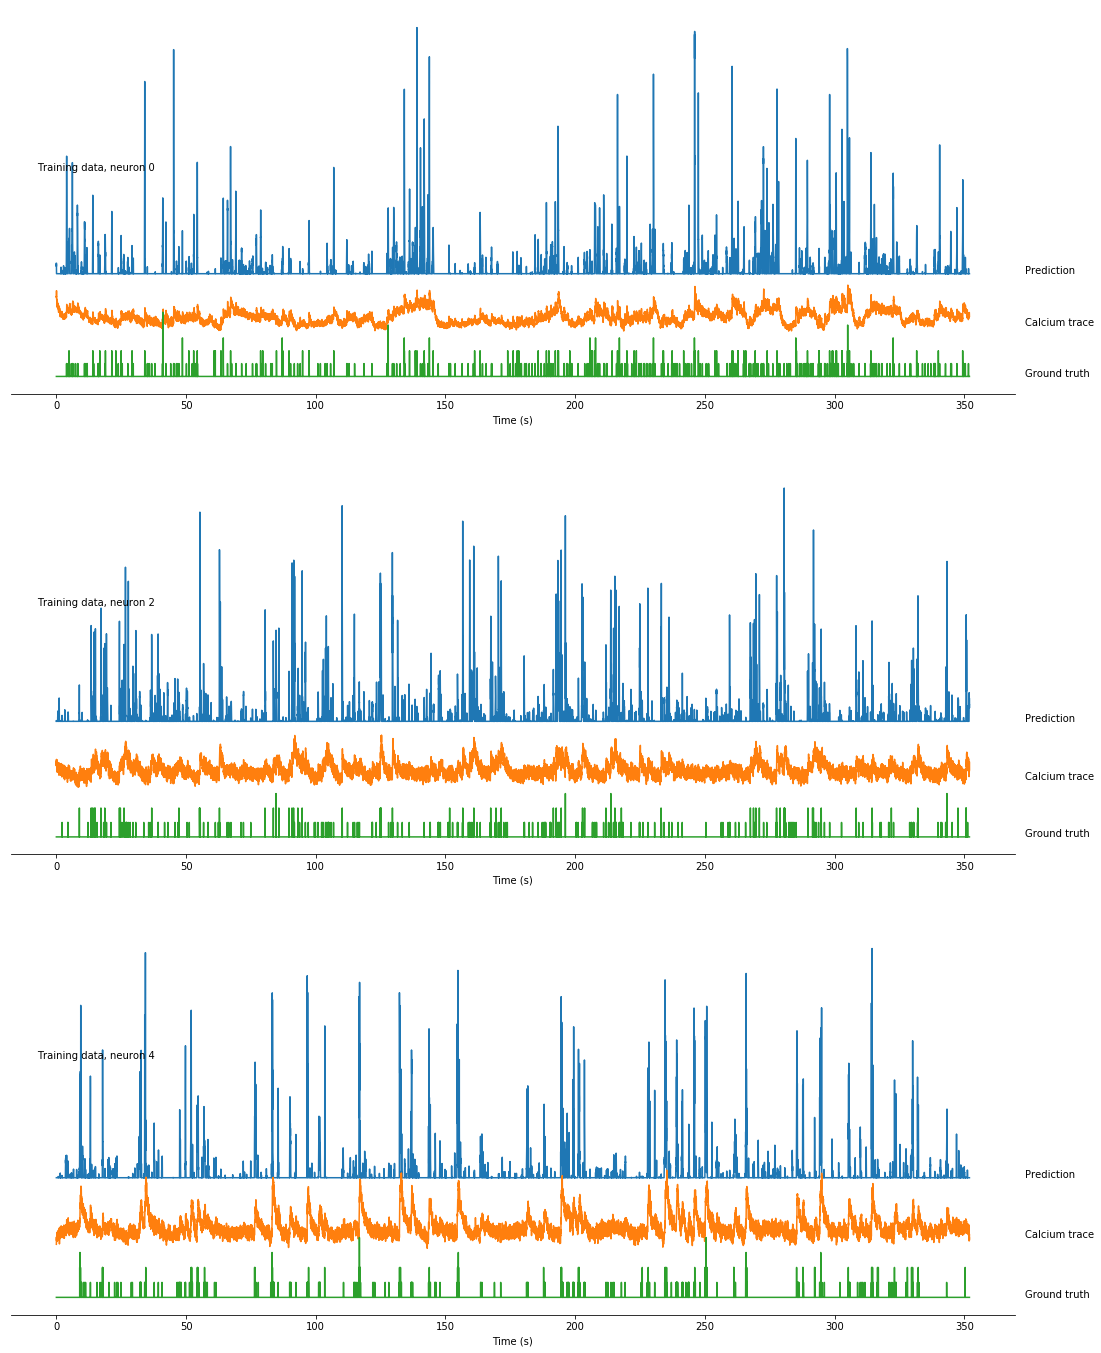

In [58]:
y_test = spikes.as_matrix()
x_test = calcium.as_matrix()
x_test_predict = preds.as_matrix()

f = plt.figure(figsize=(18,24))

# choose time window
window = np.arange(0,35200)
time_sec = window/100.0

for ii,neuron_index in zip(range(3),[0,2,4]):
    # plot predictions, calcium traces and ground truth for the test dataset
    ax = plt.subplot(3,1,ii+1)
    ax.plot(time_sec,x_test_predict[window, neuron_index])
    ax.plot(time_sec,x_test[window,neuron_index]-4)
    ax.plot(time_sec,(y_test[window,neuron_index])-8)

    # Labels and axes
    plt.text(1.01*plt.xlim()[1],0, 'Prediction')
    plt.text(1.01*plt.xlim()[1],-4, 'Calcium trace')
    plt.text(1.01*plt.xlim()[1],-8, 'Ground truth')

    plt.text(-0.02*plt.xlim()[1],8, 'Training data, neuron %s' % neuron_index)


    plt.xlabel('Time (s)')

    ax.get_yaxis().set_visible(False)
    sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=False, offset=None, trim=False)

## Zoomed in

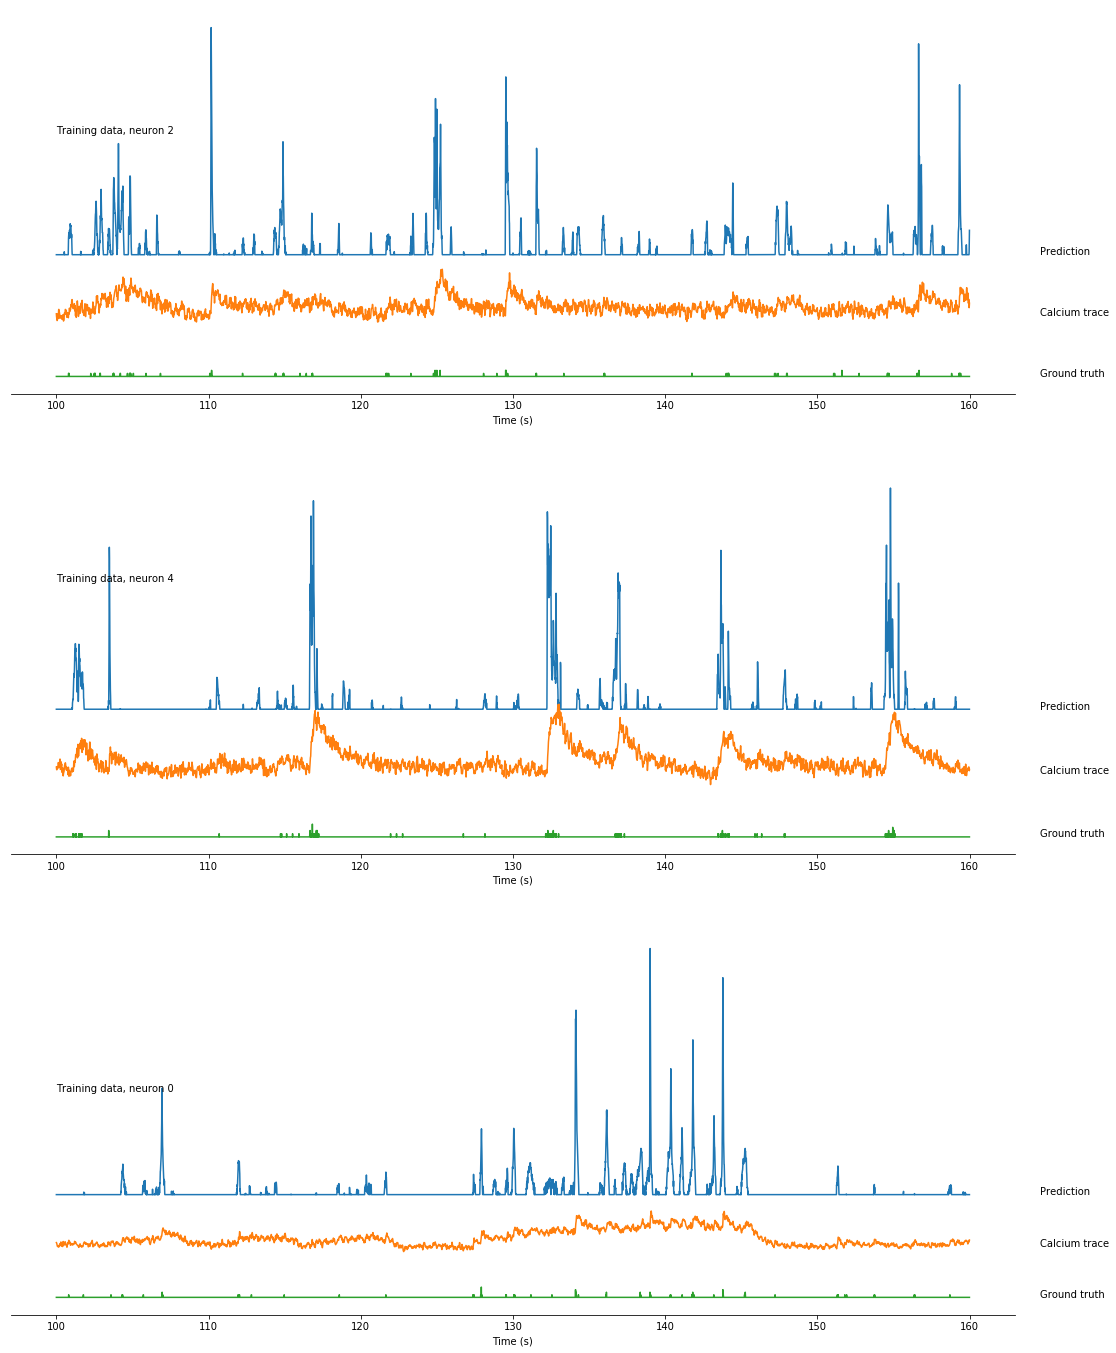

In [59]:
f = plt.figure(figsize=(18,24))

# choose time window
window = np.arange(10000,16000)
time_sec = window/100.0

for ii,neuron_index in zip(range(3),[2,4,0]):
    # plot predictions, calcium traces and ground truth for the test dataset
    ax = plt.subplot(3,1,ii+1)
    ax.plot(time_sec,x_test_predict[window,neuron_index])
    ax.plot(time_sec,x_test[window,neuron_index]-4)
    ax.plot(time_sec,(y_test[window,neuron_index])/5-8)

    # Labels and axes
    plt.text(1.01*plt.xlim()[1],0, 'Prediction')
    plt.text(1.01*plt.xlim()[1],-4, 'Calcium trace')
    plt.text(1.01*plt.xlim()[1],-8, 'Ground truth')

    plt.text(time_sec[0],8, 'Training data, neuron %s' % neuron_index)


    plt.xlabel('Time (s)')

    ax.get_yaxis().set_visible(False)
    sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=False, offset=None, trim=False)

# Refined inference

It's possible to refine the universal model to become specialized for the treatment of one recording. This is done by further training the universal model on only one dataset. This improves the predictions markedly when enough training data is available. This can be done via:

In [ ]:
!./train_and_refine.sh

In [ ]:
!./eval_all.sh

Now visualize the predictions.

In [78]:
preds = pd.read_csv("preds/universal_resnet/1.test.spikes.csv")
preds_refined = pd.read_csv("preds/universal_resnet_refined/1.test.spikes.csv")

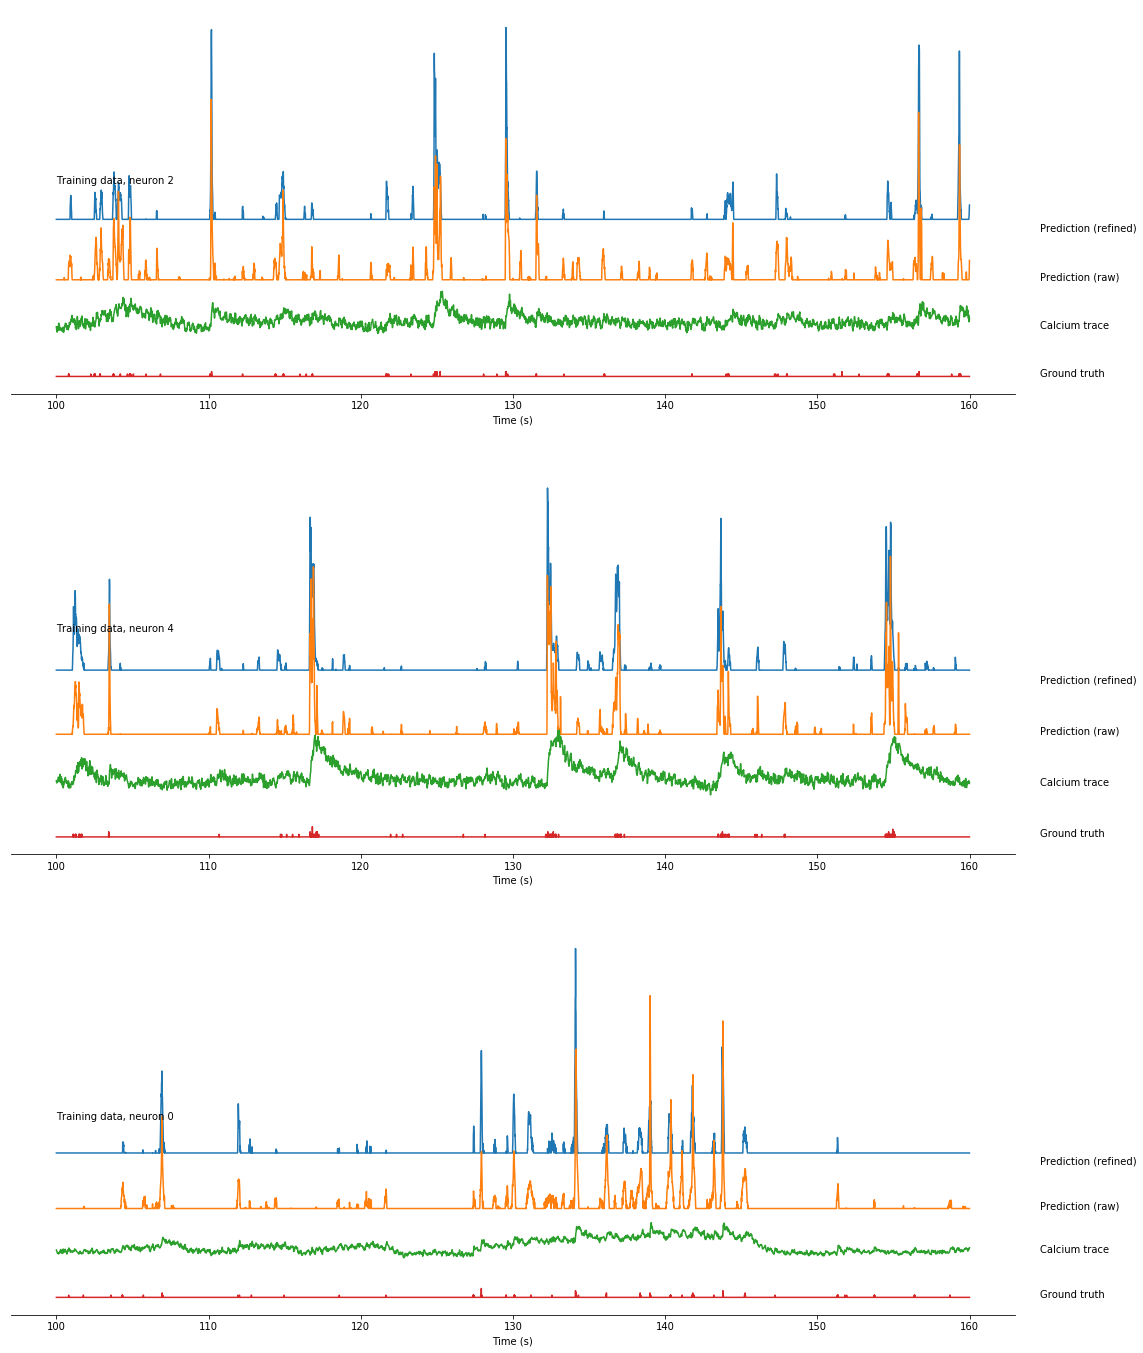

In [83]:
x_test_predict_refined = preds_refined.as_matrix()

f = plt.figure(figsize=(18,24))

# choose time window
window = np.arange(10000,16000)
time_sec = window/100.0

for ii,neuron_index in zip(range(3),[2,4,0]):
    # plot predictions, calcium traces and ground truth for the test dataset
    ax = plt.subplot(3,1,ii+1)
    ax.plot(time_sec,x_test_predict_refined[window,neuron_index]+5)
    ax.plot(time_sec,x_test_predict[window,neuron_index])
    ax.plot(time_sec,x_test[window,neuron_index]-4)
    ax.plot(time_sec,(y_test[window,neuron_index])/5-8)

    # Labels and axes
    plt.text(1.01*plt.xlim()[1],4, 'Prediction (refined)')
    plt.text(1.01*plt.xlim()[1],0, 'Prediction (raw)')
    plt.text(1.01*plt.xlim()[1],-4, 'Calcium trace')
    plt.text(1.01*plt.xlim()[1],-8, 'Ground truth')

    plt.text(time_sec[0],8, 'Training data, neuron %s' % neuron_index)


    plt.xlabel('Time (s)')

    ax.get_yaxis().set_visible(False)
    sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=False, offset=None, trim=False)

The refined predictions appear to be temporally sharper in these examples.